# Genome IGR Analysis Report 
---
## Purpose
This sheet serves to compile the results of several analytical programs run to analyze the output of a selected IGR into one easily viewable location. 

The information compiled includes:
* Number of hits
* Structure predicted by R-scape
* Structure predicted by CMfinder
* Possible sub-structures highlighted by CMfinder
* Gene Association
* Examples of specific gene context

### Necessary code imports and Preparation

In [1]:
from Bio import AlignIO, SeqIO
import random
import subprocess
import os
import pandas as pd
import glob
import re
import tarfile
import ipywidgets


%cd /home/jovyan/work
from src.data.genome_context import get_all_images, run_rscape, tar_subdir_members, build_target_coords

/home/jovyan/work


## Step 1 
---
Change the variable `import_tar_name` and `step_name` below to reflect the data being imported.

In [2]:
# Change the variables here to reflect data being imported
import_tar_name = "data/import/Campylobacter_jejuni_GCA_000009085.1_selection_0.5_2.0_-2.0_infernal_step1.done.tar.gz"
assembly_acc = "GCA_000009085.1"
selection_name = "selection_0.5_2.0_-2.0"
step_name = 'infernal_step1'

# Unpack the files 
untar_dir = "data/genomes/{}/{}".format(assembly_acc, selection_name)        
with tarfile.open(import_tar_name, "r:gz") as tar:
    tar.extractall(path=untar_dir, members=tar_subdir_members(tar, import_tar_name))

### Collect all the potential motifs in the imported directory and generate selection dropdown

In [3]:
data_dir="{}/{}".format(untar_dir, step_name)
tblout_files = glob.glob("{}/*/*.tblout".format(data_dir))        
motif_list = list(file.split('/')[-1][:-10] for file in tblout_files)
motif_dropdown = ipywidgets.Dropdown(options=motif_list, description="Motif Name",  layout={'width': 'max-content'})
motif_dropdown

Dropdown(description='Motif Name', layout=Layout(width='max-content'), options=('AL111168_1522176-1522346_igr'…

## Step 2
---
After selecting an IGR from the dropdown above, run all cells starting at this codeblock to generate the analysis data.

In [4]:
# Saves the next motif in the list of motifs to motif_name
motif_name=motif_dropdown.value
outdir="{}/{}".format(data_dir,motif_name)
sto_filename = "{}/{}.cm.align.sto".format(outdir, motif_name)
dedupe_filename = "{}/{}.dedupe.fasta".format(outdir, motif_name)
sample_filename = "{}/{}.sample.fasta".format(outdir, motif_name)
results_filename ="{}/{}.cm.tblout".format(outdir, motif_name) 

# Read in the results from the .tblout file
results_df = pd.read_csv(results_filename, skiprows=2, skipfooter=10, sep='\s+', engine='python', header=None, 
                         names=['target_name', 'target_accession', 'query_name', 'query_accession', 'mdl', 'mdl_from', 'mdl_to', 
                                'seq_from', 'seq_to', 'strand', 'trunc', 'pass', 'gc', 'bias', 'score', 'e_value', 'inc','description'])
# Remove duplicate accession numbers caused by duplicates in the searched database
results_df.drop_duplicates(inplace=True)

# Correct coordinates taking IGR database into account
results_df['target_coords'] = results_df.apply(lambda row: build_target_coords(row['target_name'], row['seq_from'], row['seq_to']), axis=1)
results_df.drop(columns=['target_accession', 'query_accession', 'inc', 'description', 'query_name'], inplace=True)

# Remove duplicate entries from the database
dedupe_fasta = list(SeqIO.parse(dedupe_filename, 'fasta'))
#   Remove nn| prefix (if found) before adding id to list
dedupe_id_list = [(re.sub('^[0-9]+\|','',record.id)) for record in dedupe_fasta]
deduped_results_df = results_df[results_df['target_coords'].isin(dedupe_id_list)].copy()

# Output results
print("Results for: {}".format(motif_name))
print("Number of Unique Hits: {}".format(len(dedupe_id_list)))

# Display up to 100 rows
with pd.option_context('display.max_rows', 100):
    display(deduped_results_df[['e_value', 'target_coords', 'gc', 'bias', 'score', 'strand', ]])

Results for: AL111168_1522176-1522346_igr
Number of Unique Hits: 132


,e_value,target_coords,gc,bias,score,strand
0,4.200000e-42,NZ_MJXO01000040.1/73947-73778,0.28,6.0,158.2,-
129,1.200000e-41,NZ_JAJR01000028.1/3287-3118,0.28,5.6,156.8,-
133,1.300000e-41,NZ_KI639643.1/114627-114458,0.28,5.5,156.7,-
134,1.700000e-41,NZ_LIRZ01000005.1/33302-33469,0.27,6.4,156.3,+
142,2.000000e-41,NZ_ANHD01000083.1/3114-2945,0.27,6.4,156.1,-
...,...,...,...,...,...,...
1572,3.200000e-03,NZ_JMTI01000051.1/43493-43320,0.29,6.5,33.7,-
1573,3.400000e-03,NZ_CP019685.1/43083-43256,0.27,7.7,33.6,+
1574,3.500000e-03,NZ_VWSJ01000004.1/13030-12860,0.27,7.7,33.5,-
1575,5.000000e-03,NZ_CP018793.1/53223-53379,0.32,3.4,33.0,+


## R-scape Structure Prediction from Co-variation

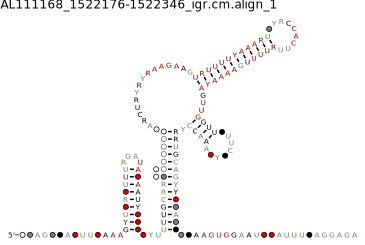

In [5]:
run_rscape(outdir, sto_filename, fold=True, output=False)

### RNAcode Analysis for Possible Protein Coding Regions

In [6]:
clustal_filename = "{}/{}/{}.sample.clustal".format(data_dir,motif_name, motif_name) 

sample_fasta = list(SeqIO.parse(sample_filename, 'fasta'))
sample_id_list = [record.id for record in sample_fasta]
sto_records = list(SeqIO.parse(sto_filename, 'stockholm'))
sampled_sto_records = [record for record in sto_records if record.id in sample_id_list]

alignment = sampled_sto_records[:200]

with open(clustal_filename, 'w') as clustal_file:
    SeqIO.write(alignment, clustal_file, "clustal")
    
output = subprocess.run(['RNAcode', clustal_filename], capture_output=True)

print(output.stdout.decode())
print(output.stderr.decode())


 HSS # Frame Length  From    To        Name       Start         End    Score        P
     0    +2      4    26    29NZ_MJXO01000040.1/73947-73778          77          88     5.32    0.333
     1    -2      6    31    36NZ_MJXO01000040.1/73947-73778          92         109     5.14    0.372
     2    +2      3    54    56NZ_MJXO01000040.1/73947-73778         161         169     2.22    0.987
     3    -1      4    21    24NZ_MJXO01000040.1/73947-73778          61          72     1.55    0.999
     4    -2      5    44    48NZ_MJXO01000040.1/73947-73778         131         145     1.08    1.000
     5    +1      3    33    35NZ_MJXO01000040.1/73947-73778          97         105     1.06    1.000

1 alignment(s) scored in 5.67 seconds. Parameters used:
N=100, Delta=-10.00, Omega=-4.00, omega=-2.00, stop penalty=-8.00





### CMfinder Motif Discovery

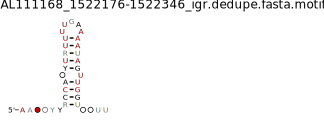

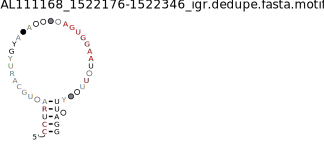

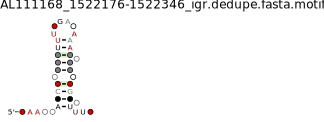

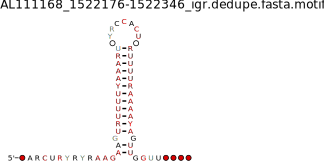

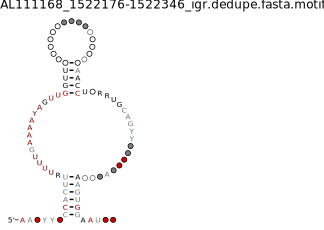

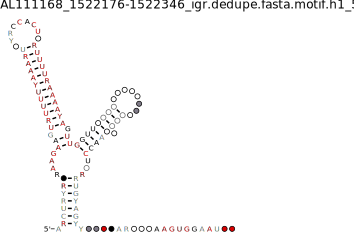

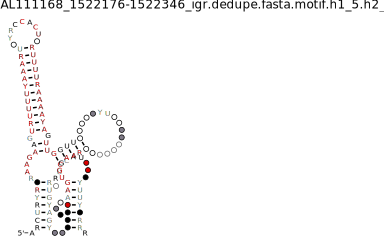

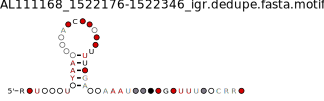

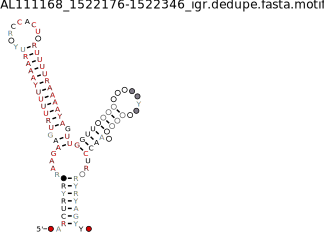

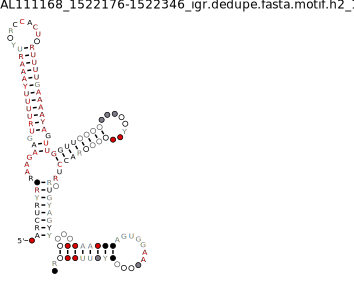

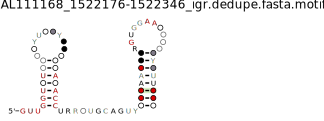

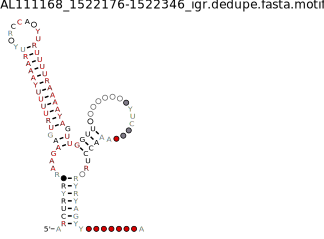

In [7]:
import os

def check_motif(motif):
    for fragment in ['cov', 'dplot', 'power', 'R2R', 'sorted', 'surv', 'temp.gap', 'svg', 'ps']:
        if fragment in motif:
            return False
    return True

motif_files = glob.glob("{}/{}/*fasta.motif*".format(data_dir, motif_name))
# Get the list of all the motif portions predicted by cmfinder
cmfinder_motifs = [file[file.rfind('motif')+6:] for file in motif_files]
# Remove duplicates
cmfinder_motifs = list(set(cmfinder_motifs))
# Remove motifs with '.temp.gap'
cmfinder_motifs = [ motif for motif in cmfinder_motifs if check_motif(motif)]

completed_motifs = []

cmfinder_motifs.sort()
for motif in cmfinder_motifs:
    file = "{}/{}.dedupe.fasta.motif.{}".format(outdir, motif_name, motif)
    if file[-4:] != '.sto':
        os.rename(file, "{}.sto".format(file))
        file = "{}.sto".format(file)
    if file not in completed_motifs:
        run_rscape(outdir, file, fold=False, output=False)
        completed_motifs.append(file)
    
all_files = glob.glob("{}/{}/*".format(data_dir, motif_name))


## Genome Context Images

Match #1
E-value: 4.2e-42
%GC: 0.28
Score: 158.2
Genome Assembly: GCF_001762835.1_ASM176283v1
Target: NZ_MJXO01000040.1/73947-73778
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


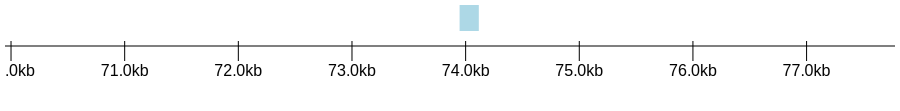

Match #130
E-value: 1.1999999999999999e-41
%GC: 0.28
Score: 156.8
Genome Assembly: GCF_001419395.1_Campylobacter_coli_CVM_41963_v1.0
Target: NZ_JAJR01000028.1/3287-3118
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGGCAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


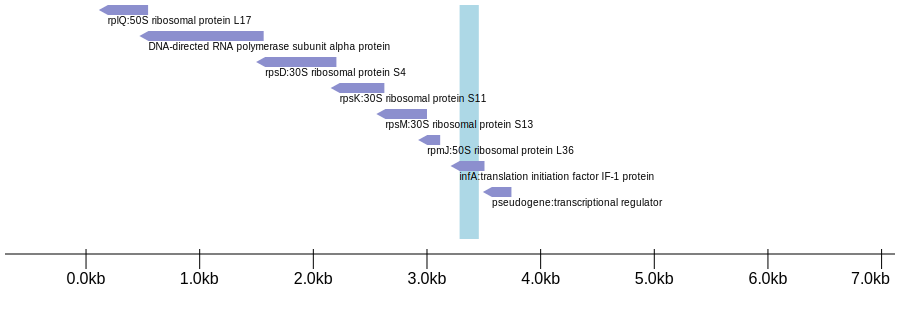

Match #134
E-value: 1.3e-41
%GC: 0.28
Score: 156.7
Genome Assembly: GCF_000505605.1_K3
Target: NZ_KI639643.1/114627-114458
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


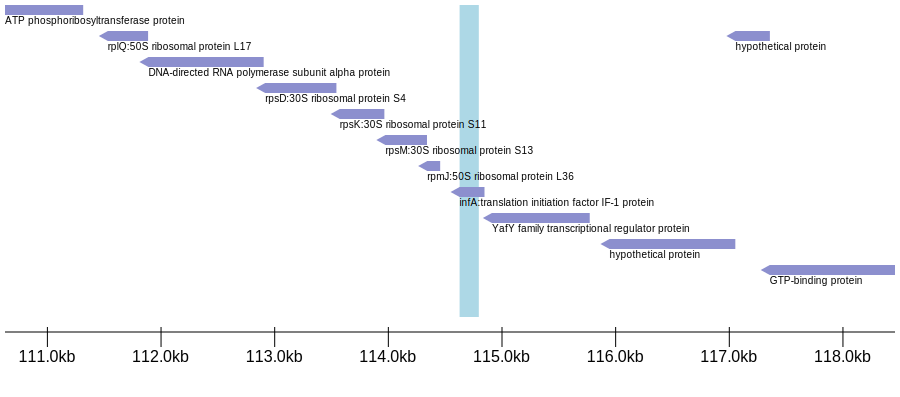

Match #135
E-value: 1.7e-41
%GC: 0.27
Score: 156.3
Genome Assembly: GCF_001545365.1_ASM154536v1
Target: NZ_LIRZ01000005.1/33302-33469
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


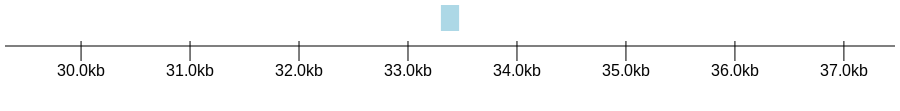

Match #143
E-value: 2e-41
%GC: 0.27
Score: 156.1
Genome Assembly: GCF_000314385.1_ASM31438v1
Target: NZ_ANHD01000083.1/3114-2945
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUUAAGGAGACGCU


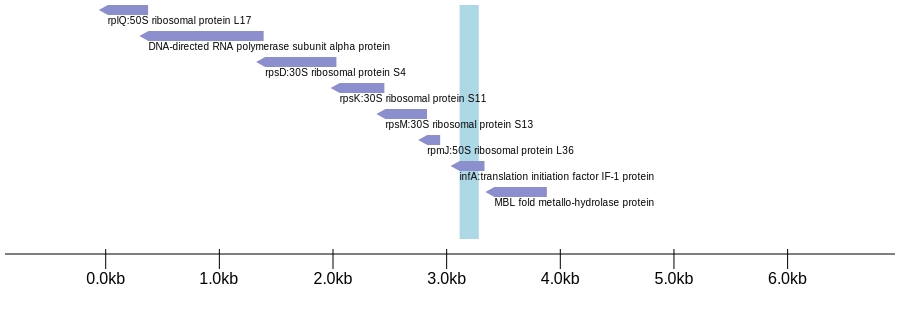

Match #144
E-value: 7.8e-41
%GC: 0.28
Score: 154.2
Genome Assembly: GCF_001762325.1_ASM176232v1
Target: NZ_MJWQ01000082.1/29388-29557
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUACGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUGGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


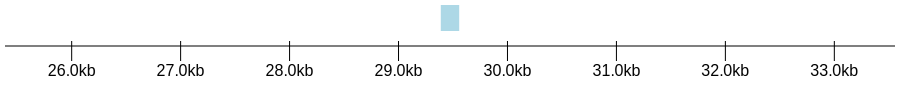

Match #145
E-value: 2.7e-40
%GC: 0.28
Score: 152.4
Genome Assembly: GCF_001488215.1_NCTC12569
Target: NZ_FBGT01000020.1/136591-136421
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGACAAAUUACAUCGAAgCUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


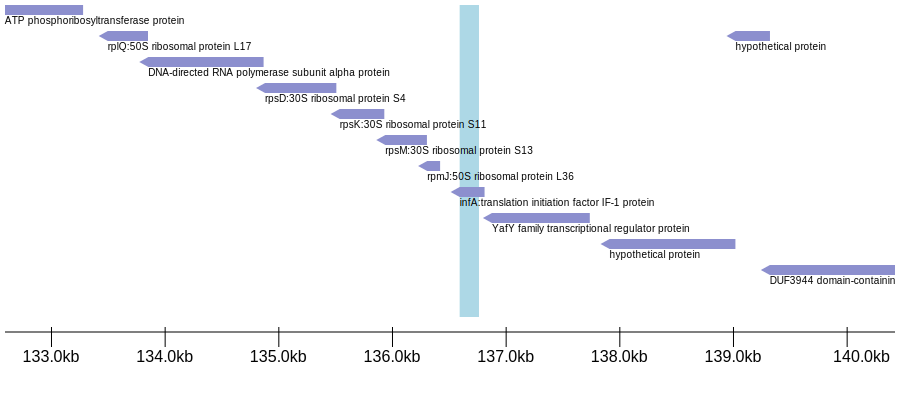

Match #146
E-value: 1.9e-38
%GC: 0.26
Score: 146.5
Genome Assembly: GCF_001232025.1_7038_3_93
Target: NZ_CULD01000002.1/33677-33845
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUGCGACAAAUUACAUCGAACUAUAUGAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUUGUAAAUCAAGUGGAAUUCAUUUAAGGAGACGCU


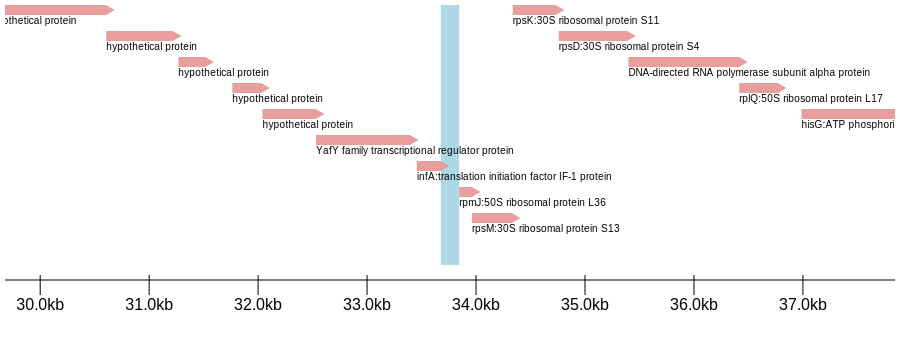

Match #147
E-value: 4.8e-37
%GC: 0.28
Score: 142.0
Genome Assembly: GCF_001417185.1_ASM141718v1
Target: NZ_LBEM01000015.1/33240-33073
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


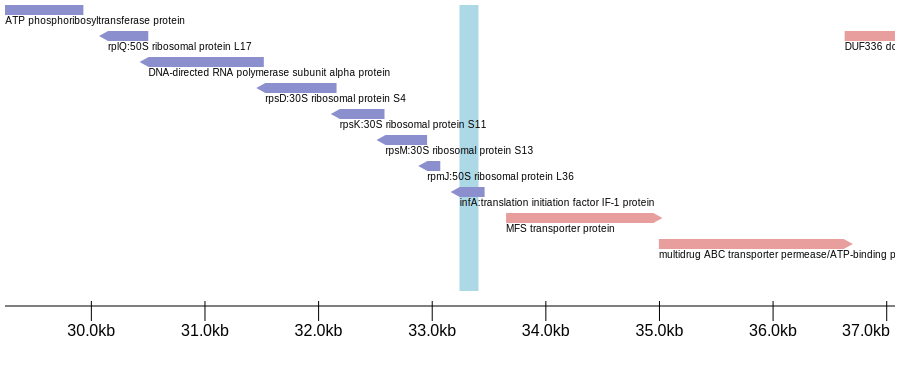

Match #148
E-value: 1.4e-35
%GC: 0.27
Score: 137.3
Genome Assembly: GCF_001579545.1_ASM157954v1
Target: NZ_LKCQ01000016.1/106871-106706
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUCCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


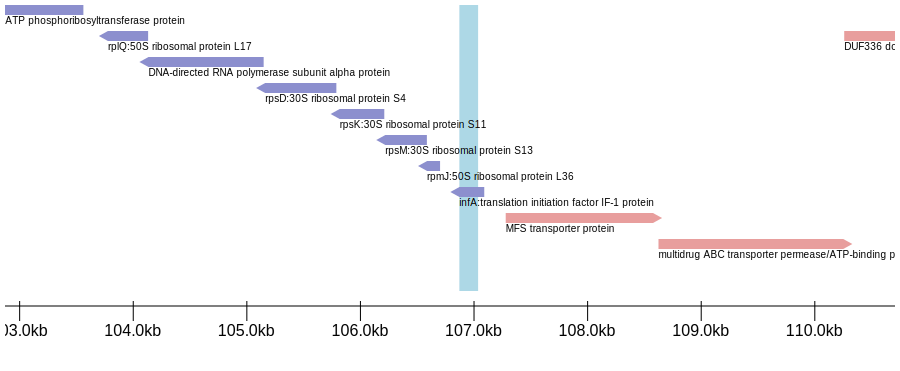

Match #149
E-value: 2.2e-35
%GC: 0.26
Score: 136.7
Genome Assembly: GCF_001865535.1_ASM186553v1
Target: NZ_CP017875.1/292195-292030
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGAGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


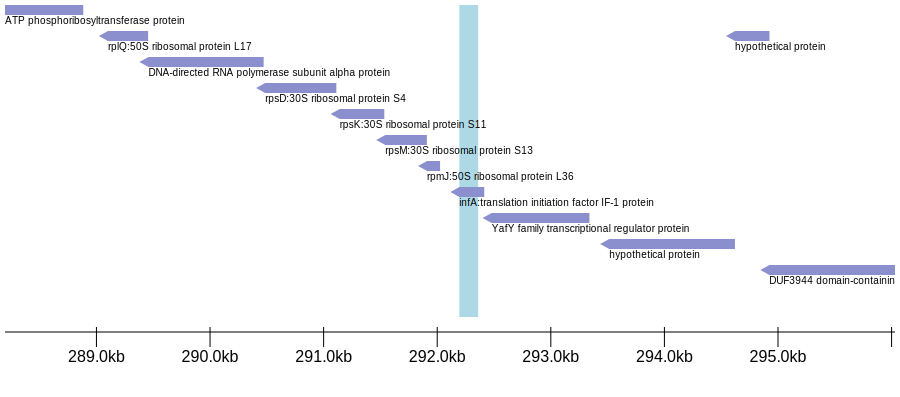

Match #150
E-value: 3.7999999999999996e-35
%GC: 0.27
Score: 135.9
Genome Assembly: GCF_001762225.1_BCW_6447
Target: NZ_MJWL01000032.1/33767-33930
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


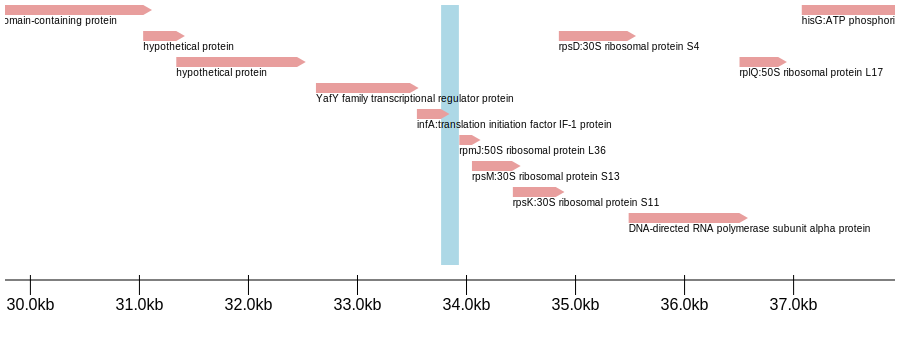

Match #154
E-value: 6.5e-35
%GC: 0.27
Score: 135.2
Genome Assembly: GCF_000253935.1_ASM25393v2
Target: NZ_AINI01000011.1/4542-4707
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


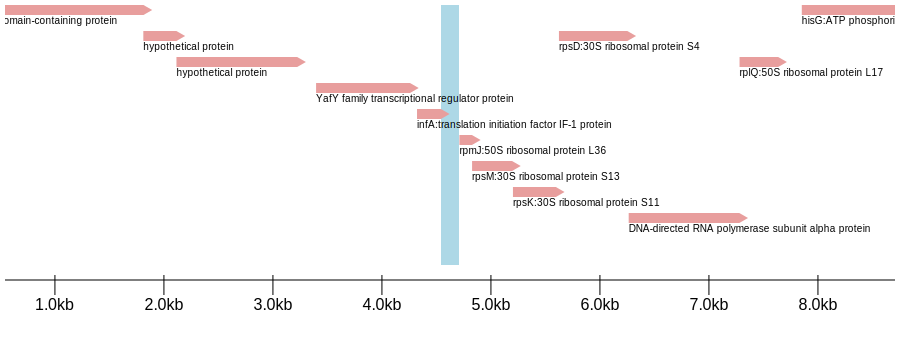

Match #156
E-value: 2.6e-34
%GC: 0.26
Score: 133.3
Genome Assembly: GCF_000146835.1_ASM14683v1
Target: NZ_GL405235.1/853024-853187
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


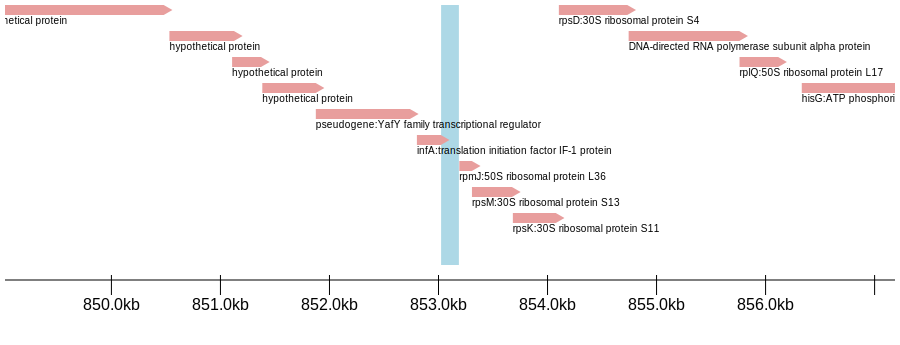

Match #896
E-value: 3.3e-34
%GC: 0.26
Score: 132.9
Genome Assembly: GCF_001229965.1_7065_7_93
Target: NZ_CUOV01000002.1/165550-165713
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGUGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


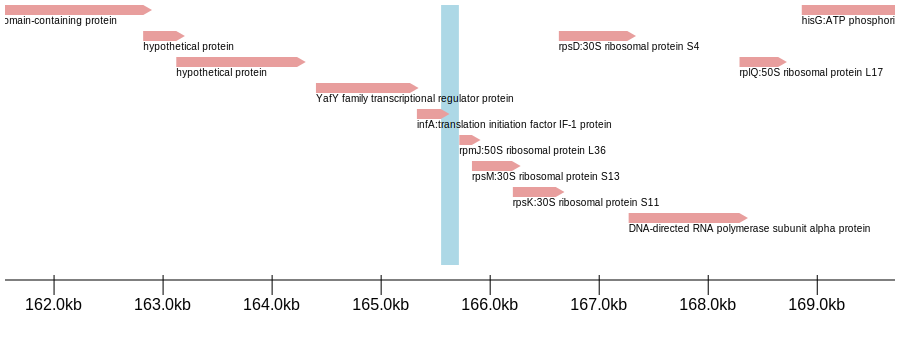

Match #900
E-value: 7.0000000000000006e-34
%GC: 0.27
Score: 131.9
Genome Assembly: GCF_001495655.1_H073180384
Target: NZ_FBJW01000007.1/33718-33881
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUGUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


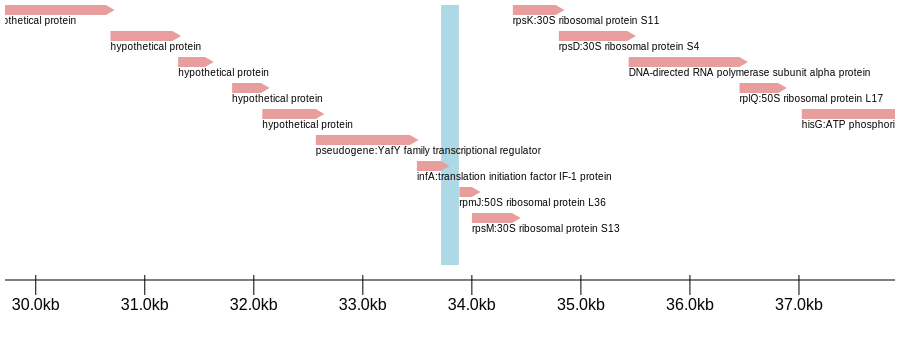

Match #901
E-value: 7.0000000000000006e-34
%GC: 0.27
Score: 131.9
Genome Assembly: GCF_001490535.1_H042280284
Target: NZ_FBQS01000018.1/29563-29726
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUGGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


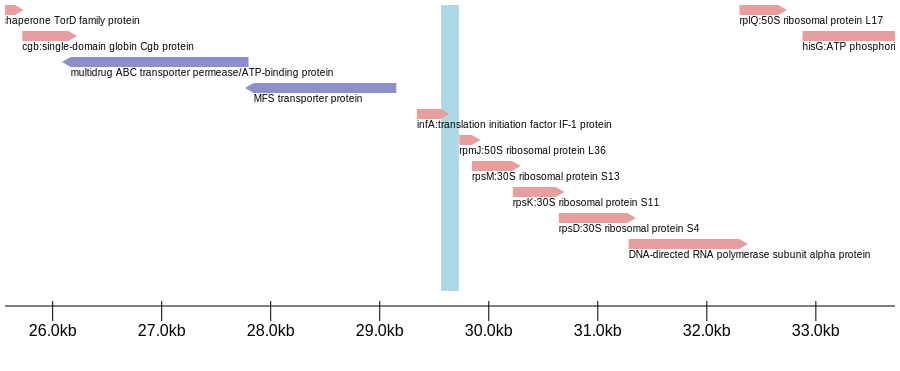

Match #905
E-value: 7.0000000000000006e-34
%GC: 0.27
Score: 131.9
Genome Assembly: GCF_001239285.1_7065_7_86
Target: NZ_CUON01000004.1/33767-33930
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAGUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


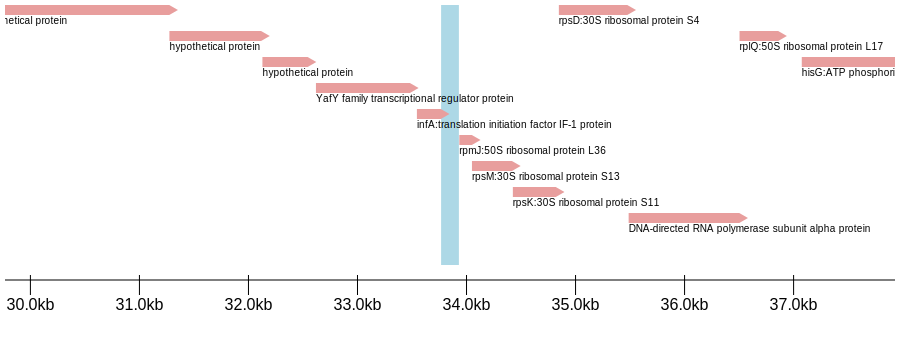

Match #932
E-value: 7.0000000000000006e-34
%GC: 0.27
Score: 131.9
Genome Assembly: GCF_000253955.2_ASM25395v3
Target: NZ_AINJ01000004.1/29695-29532
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAGAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


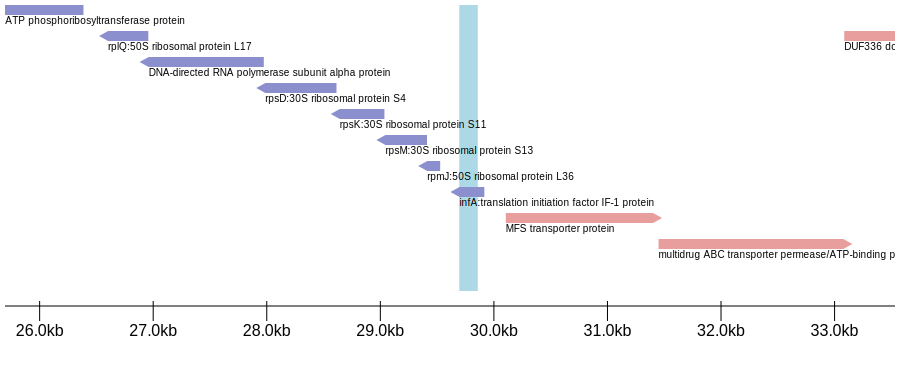

Match #940
E-value: 1.7e-33
%GC: 0.26
Score: 130.6
Genome Assembly: GCF_000314205.1_ASM31420v1
Target: NZ_ANGU01000024.1/26440-26277
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter coli
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAACGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


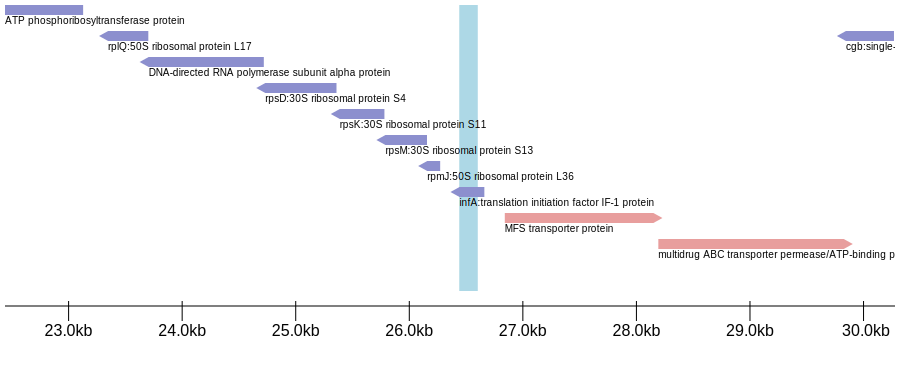

Match #995
E-value: 1.7e-33
%GC: 0.26
Score: 130.6
Genome Assembly: GCF_002019885.1_ASM201988v1
Target: NZ_MPIR01000004.1/29865-30028
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUACAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


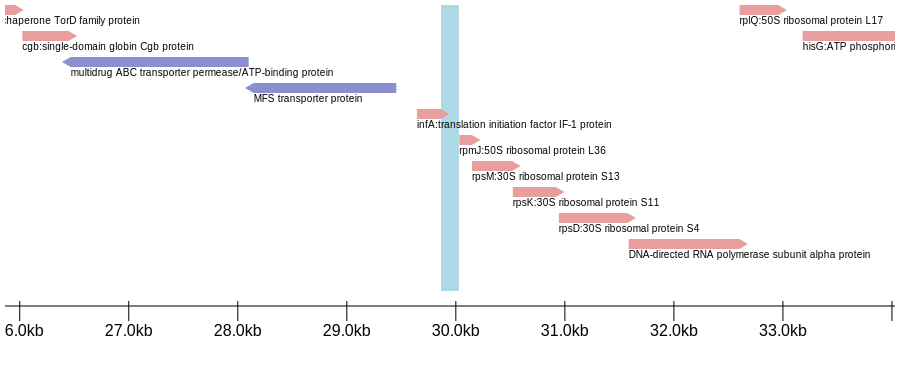

Match #998
E-value: 1.7e-33
%GC: 0.26
Score: 130.6
Genome Assembly: GCF_001416755.1_ASM141675v1
Target: NZ_LBEL01000004.1/108253-108090
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCUUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


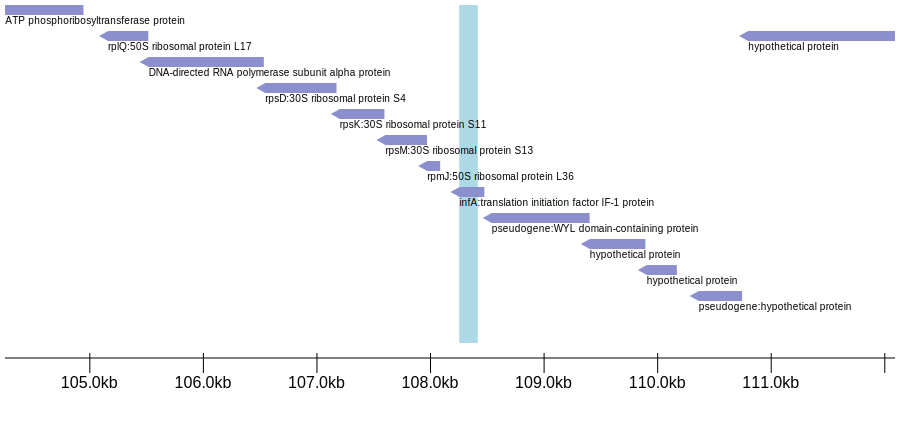

Match #1009
E-value: 6.2e-33
%GC: 0.26
Score: 128.8
Genome Assembly: GCF_001490715.1_p494A
Target: NZ_FBLC01000009.1/134519-134355
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAGCGUUUUUGCGACAAaAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


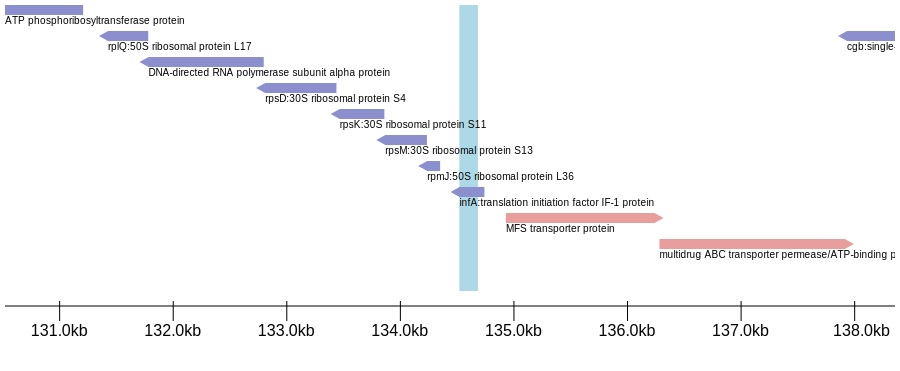

Match #1010
E-value: 9e-33
%GC: 0.26
Score: 128.3
Genome Assembly: GCF_001492115.1_SWAN308
Target: NZ_FBHA01000031.1/33442-33605
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGGUAAUUUUAGAUAAAAUUAACGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


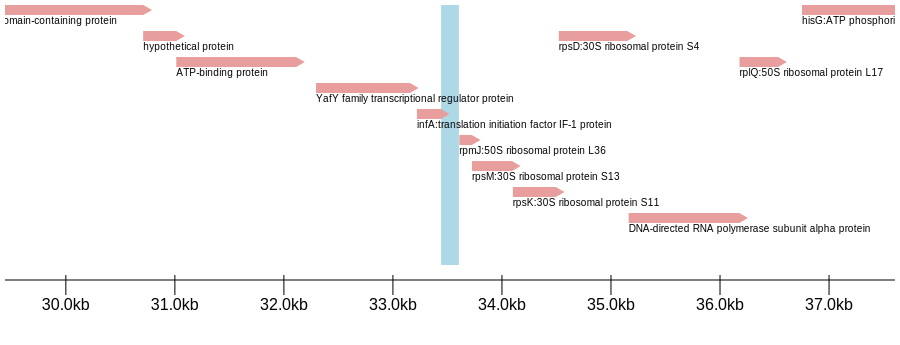

Match #1011
E-value: 1.1e-32
%GC: 0.25
Score: 128.0
Genome Assembly: GCF_002020035.1_ASM202003v1
Target: NZ_MPIU01000002.1/137192-137029
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAACAUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


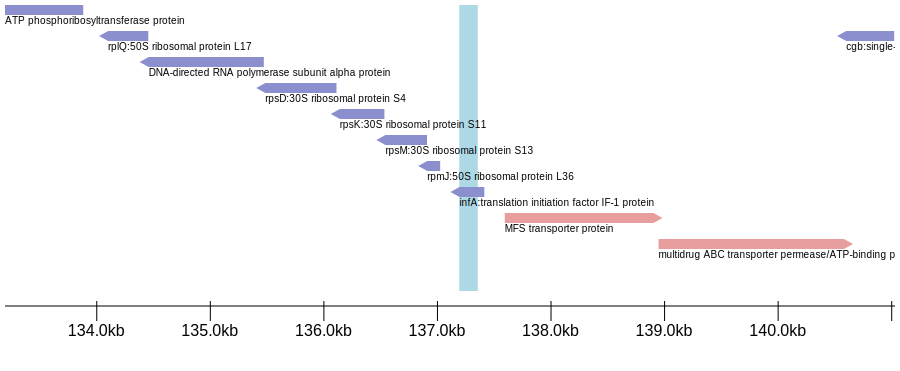

Match #1012
E-value: 1.1e-32
%GC: 0.25
Score: 128.0
Genome Assembly: GCF_001490995.1_H093580632
Target: NZ_FBPP01000038.1/125974-125811
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAACGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUACAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


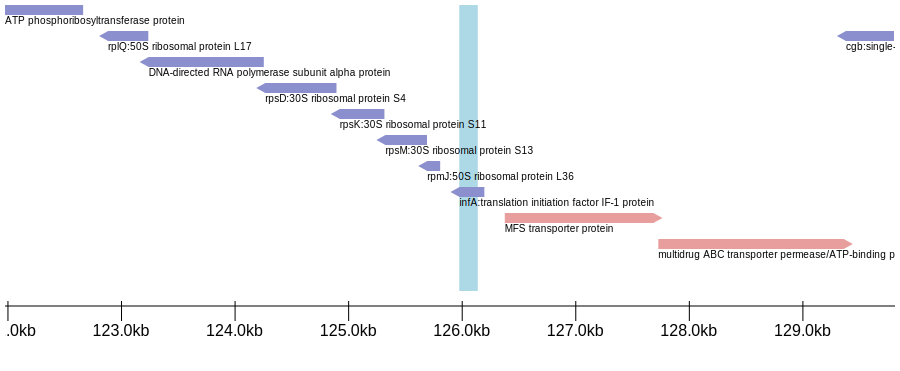

Match #1013
E-value: 1.5e-32
%GC: 0.24
Score: 127.6
Genome Assembly: GCF_001495915.1_CCN398
Target: NZ_FBMR01000031.1/107692-107529
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAACGUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUACAGUCGUAAAUAAAGUGGAAUUCAUUUAAGGAGA


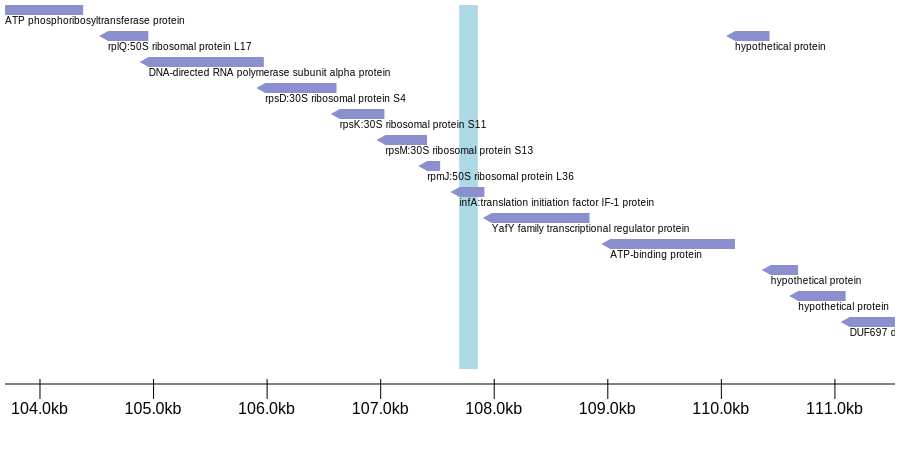

Match #1016
E-value: 7.7e-32
%GC: 0.24
Score: 125.3
Genome Assembly: GCF_001498735.1_p515C
Target: NZ_FBLM01000055.1/110043-109880
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUUAUUUAAAAGCUAAUUUUAGAUAAAAUUAACAUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUACAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


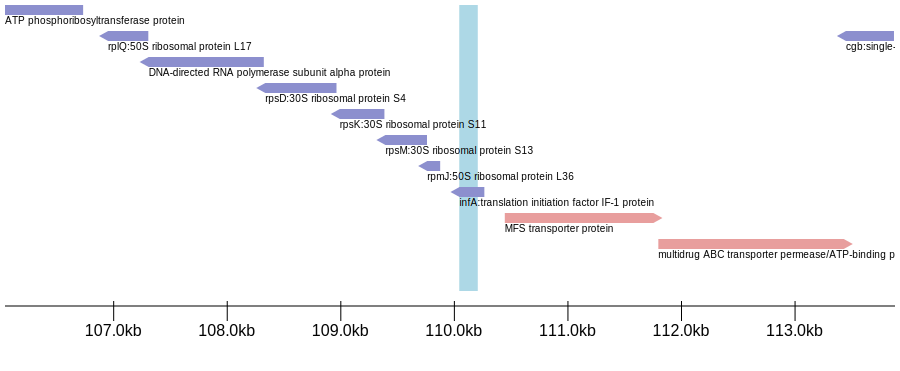

Match #1017
E-value: 2.6999999999999997e-31
%GC: 0.26
Score: 123.6
Genome Assembly: GCF_009362725.1_ASM936272v1
Target: NZ_WHME01000007.1/72276-72107
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAUUUUAAAUAUAAUUAGAAUUUUGCGACAAAUUGCAUCGAaACUAUAUGAAGAAGUAUUUCUAAAAUCCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAACUAAGUGGAAUUUAcUUAAAGGAGACGC


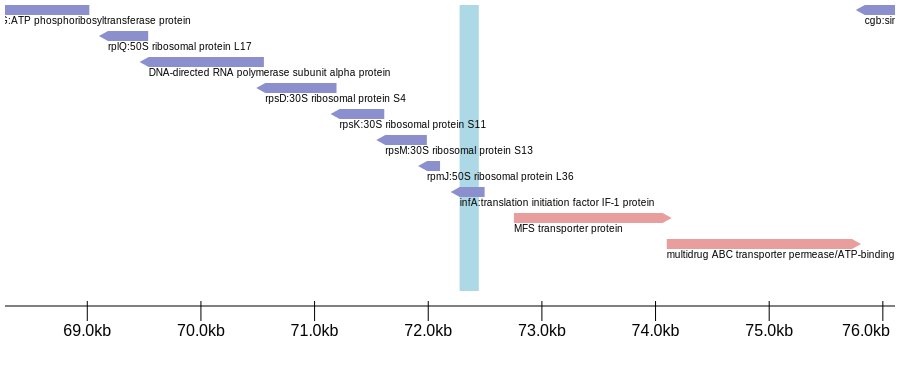

Match #1018
E-value: 5e-31
%GC: 0.25
Score: 122.7
Genome Assembly: GCF_004378855.1_ASM437885v1
Target: NZ_RYYL01000002.1/28413-28579
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGUUUUUUUUAGAUAAAAUUAGCAUUUUUGCGACAAAAUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUCAAGUGGAAUUUAUUuUAAGGAGA


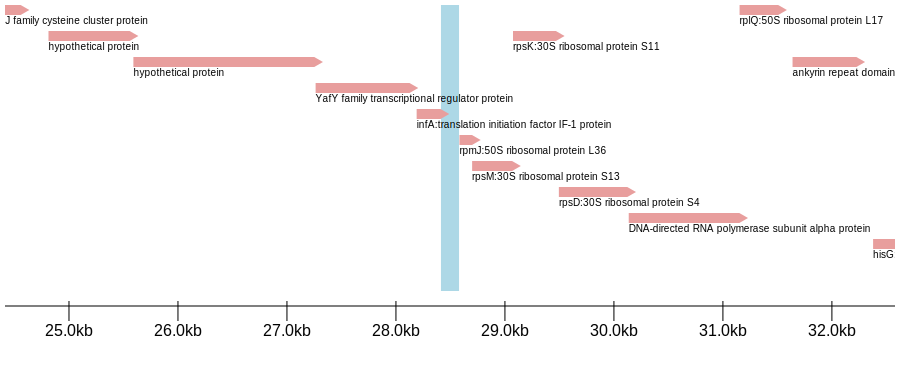

Match #1019
E-value: 3.8e-30
%GC: 0.23
Score: 119.9
Genome Assembly: GCF_001687475.2_ASM168747v2
Target: NZ_CP031611.1/1363522-1363350
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGUUAAUUUUAGAUACAAUUAGAAUUUUUGCGACAAAUUACAUCAAACUCUAUGAaAGAAGUAUUUUUAAAAUCUACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAaaaAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUUAUUuaCAAGGAGAU


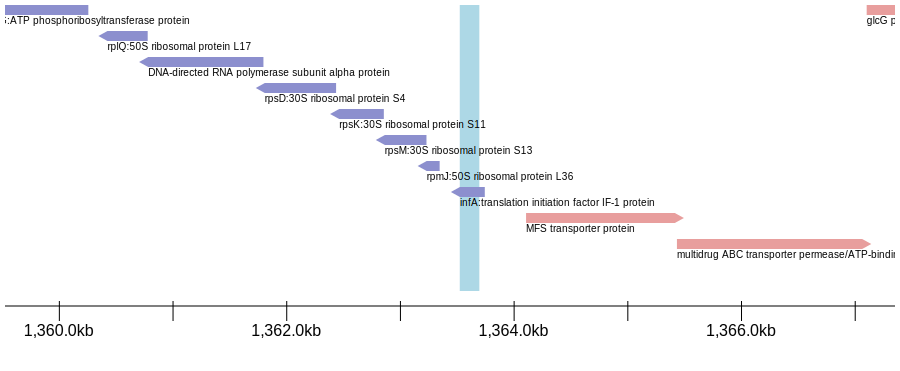

Match #1050
E-value: 2.8999999999999997e-27
%GC: 0.28
Score: 110.7
Genome Assembly: GCF_005406225.1_ASM540622v1
Target: NZ_NXLY01000001.1/74113-74280
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGCUAAUUAAAAGUUUUUUUUCGAUAAAAUUAGCGUUUUUGCGACAUUUUGUAUCGAACUAUGAAAGAAGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGCAAAUCAAGUGGAAUUUACUUaaAAGGAGACGC


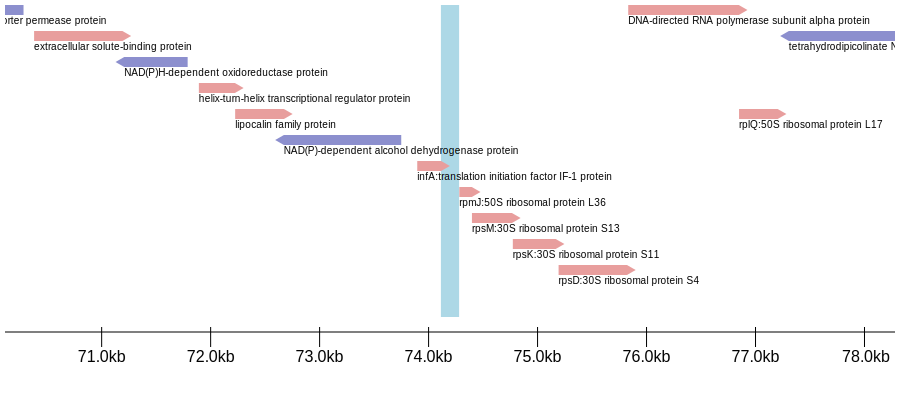

Match #1051
E-value: 3.5000000000000004e-26
%GC: 0.27
Score: 107.2
Genome Assembly: GCF_005406205.1_ASM540620v1
Target: NZ_NXLZ01000003.1/68423-68591
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGCUAAUUAAAAGUUUUUUUUCGAUAAAAUUAGCAUUUUUGCGACAUUUUGUAUCGAACUAUGAAAGAAGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGCAAAUCAAGUGGAAUUUACUUaauAAGGAGACGC


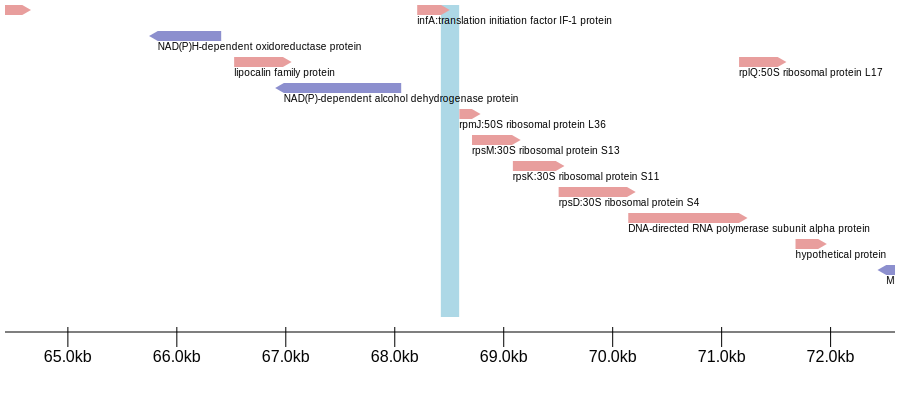

Match #1052
E-value: 3e-23
%GC: 0.3
Score: 97.8
Genome Assembly: GCF_005406215.1_ASM540621v1
Target: NZ_NXMA01000002.1/77137-77304
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGCUAUUUAAAAGUUUUUUUUCGAUAGAAUUAGCGUUUUGCGAUAUUUGUAUCGAACUAUGAAAGAAGUAUUUUUAAAAUCCACCACUUAUUUUAAAAAUAGUUGGUUGUUCGUAAAACCUGAUGCAGUCGCAAAUUAAGUGGAAUUUACUuaaaCAAGGAGACGC


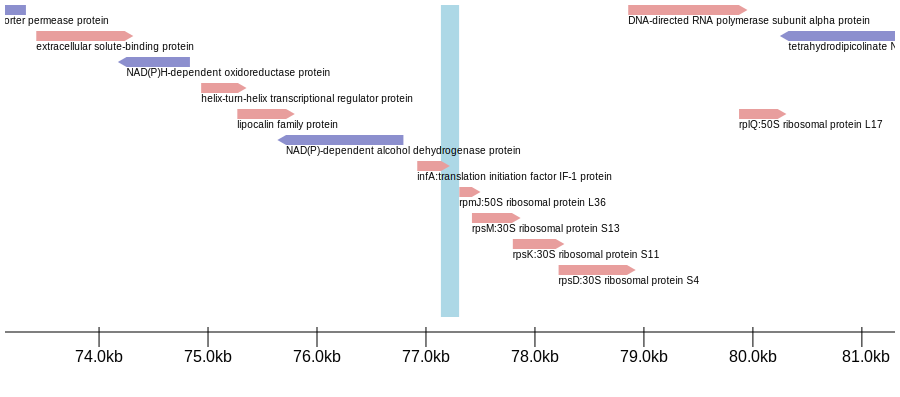

Match #1053
E-value: 1.2e-20
%GC: 0.25
Score: 89.5
Genome Assembly: GCF_006348485.1_ASM634848v1
Target: NZ_SYRX01000001.1/98211-98058
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUUUUUAUAAAAAUAuuuuUAGGCUAUGUUaaaAUAAAGuaUGUAUCGAACUAUAUGAAGAGGUAUUUUUAAAAUUCACCACUUAUUUUAAAAAUAGUUGGUUAUUCAUAAAACCUGAUGCAGUCGUAAAUGAAGUGGAAUUCAUUUAAGGAGA


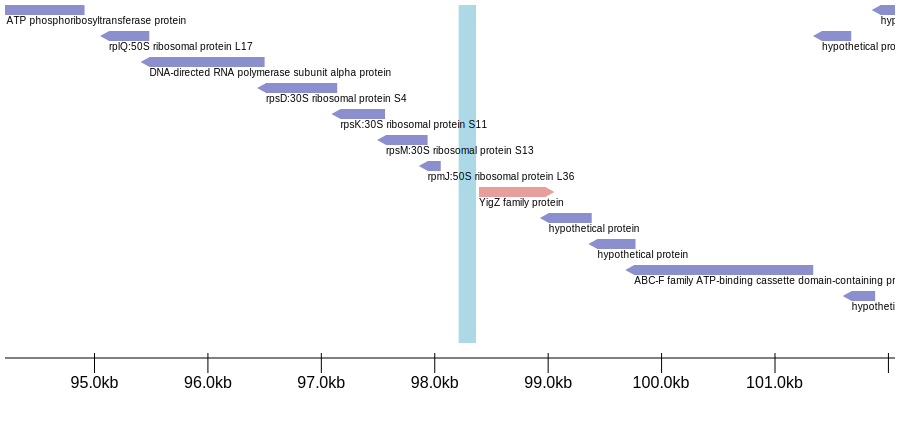

Match #1054
E-value: 4.4e-20
%GC: 0.28
Score: 87.7
Genome Assembly: GCF_000816345.1_ASM81634v1
Target: NZ_CP007774.1/71322-71476
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter volucris
Matched Sequence: UCUAAGUUAUUUAAAAGCAAAGCUAAGAUAUAAUUAGCACUUUUGCAGAAAUUGCAAUCAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUAGUCAAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


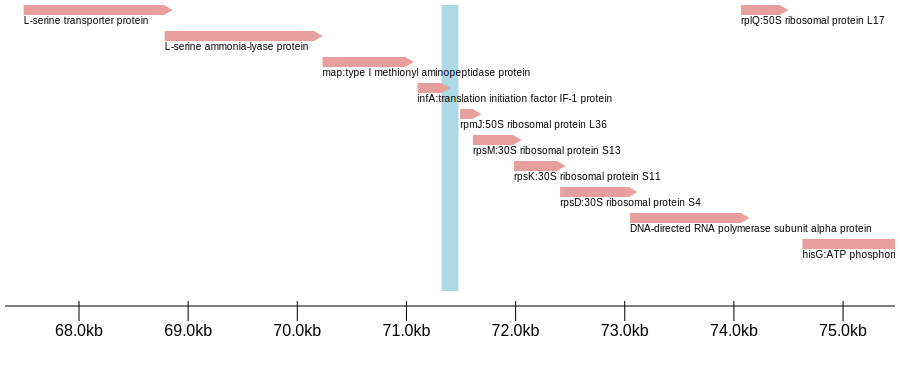

Match #1061
E-value: 1.6000000000000002e-19
%GC: 0.26
Score: 85.9
Genome Assembly: GCF_000816185.1_ASM81618v1
Target: NZ_CP007770.1/75588-75746
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter insulaenigrae
Matched Sequence: UCUAAGUUAUUUAAAAGCAAAAUUAAGCUAUCAUUAGCACUUUUGCAGAAAUUGCAAUUAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAAAAAACCUGAUGCAGUUGUAAAaaaCAAAGUGGAAUUUAC


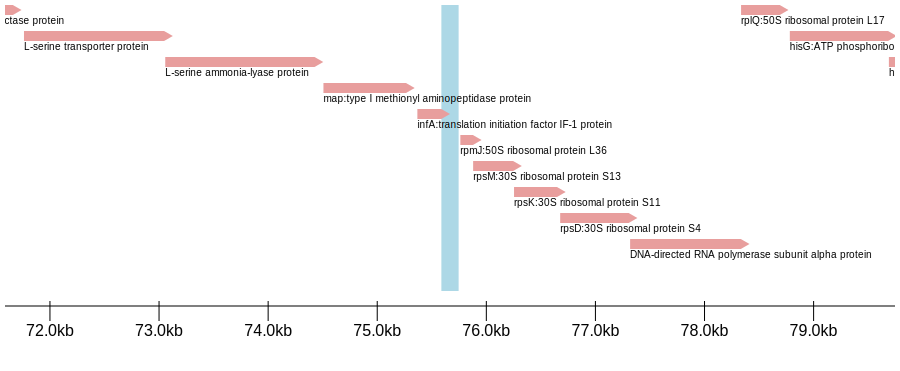

Match #1065
E-value: 7.6e-19
%GC: 0.26
Score: 83.7
Genome Assembly: GCF_008011495.1_ASM801149v1
Target: NZ_VOWB01000068.1/23559-23720
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAGUUAAGAUAUAAUUAGCACUUUUUGCAGAAAUUGCaAUUAAACUGUAUGAAGAAGUAUUUUCAAAAUUACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGAUGCAGUUGUAAAAucAAAGUGGAAUUUACAUA


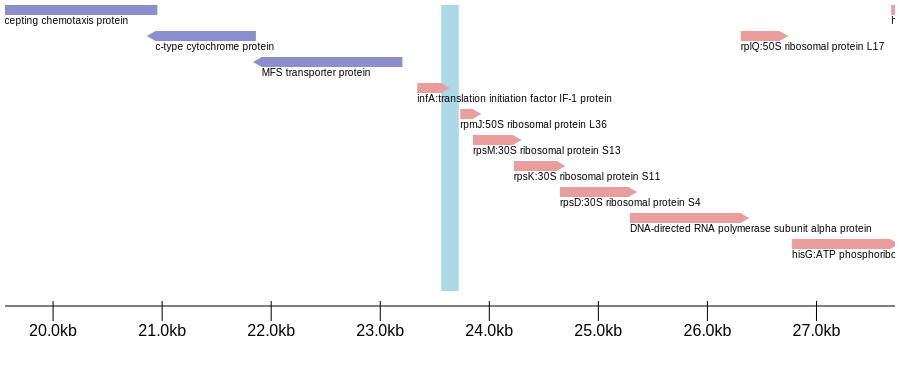

Match #1066
E-value: 9.599999999999999e-19
%GC: 0.27
Score: 83.4
Genome Assembly: GCF_008011665.1_ASM801166v1
Target: NZ_VOWJ01000023.1/35412-35258
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUGUUUAAAAGAAAAACUAAGAUAUAAUUAGUGCUUUUGCAGAAAUUGCAAUCAAACUGUAUGAAGAAGUAUUUUCAAAAUUACCACUUAUUUUGAAAAUAGUUGGUUAGUCAAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


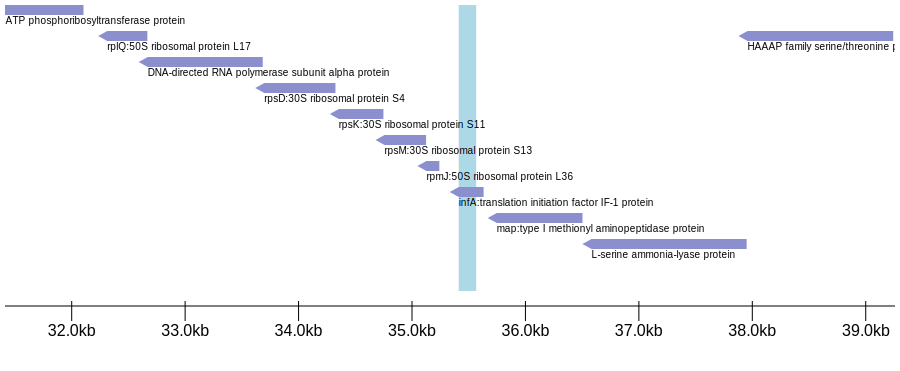

Match #1067
E-value: 5.5e-18
%GC: 0.25
Score: 81.0
Genome Assembly: GCF_000816785.1_ASM81678v1
Target: NZ_CP007766.1/76868-77029
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter peloridis
Matched Sequence: UCUAAGUUAUUUAAAAGCUAAAAUAAGAUAUAAUUAGCACUUUUUGCAGAAAUUGCaAUUAAACUGUAUGAAGAAGUAUUUUCAAAAUUACCACUUAUUUUGAAAAUAGUUGGUUGUUCUAAAAACCUGGUGCAGUUGUAAAauUAAAGUGGAAUUUACAUA


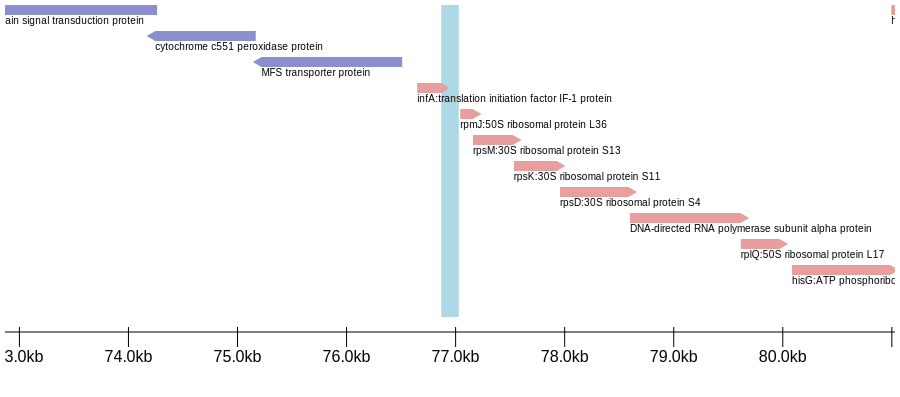

Match #1068
E-value: 6.6e-18
%GC: 0.27
Score: 80.7
Genome Assembly: GCF_000019205.1_ASM1920v1
Target: NC_012039.1/78677-78838
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter lari
Matched Sequence: UCUAAGUUGUUUAAAAGCAAAAGUAGAAUAUAAUUAGCACUUUUGCAGAAAUUGCAAUUAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAAAAAACCUGGUGCAGUUGUAAAAucAAAGUGGAAUUUACAUAA


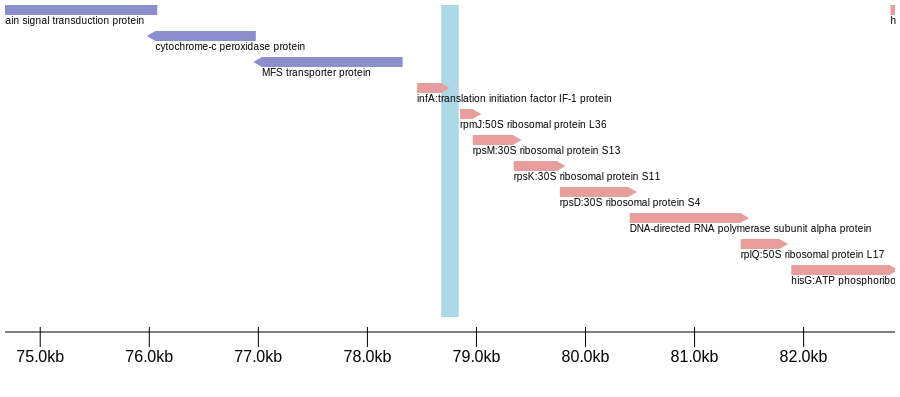

Match #1072
E-value: 6.800000000000001e-18
%GC: 0.26
Score: 80.7
Genome Assembly: GCF_000816245.1_ASM81624v1
Target: NZ_CP007769.1/78161-78315
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCAAAAGUAAGGUAUAAUUAUUGCUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUAUUCUAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


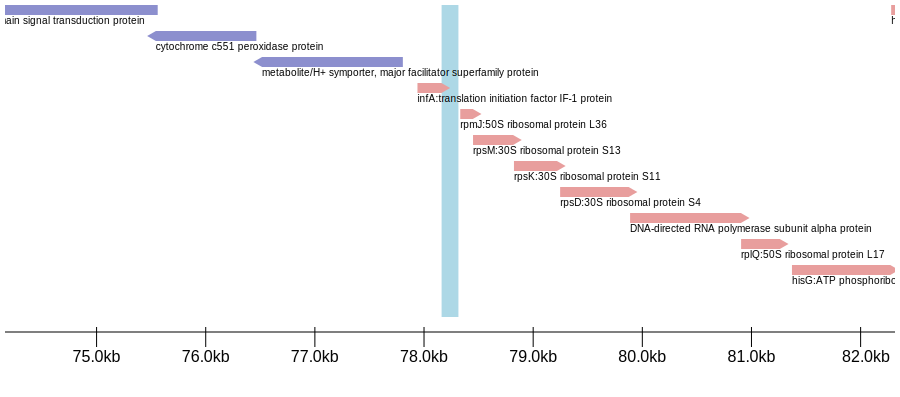

Match #1073
E-value: 7.000000000000001e-18
%GC: 0.27
Score: 80.6
Genome Assembly: GCF_006176025.1_ASM617602v1
Target: NZ_SBEV01000008.1/31738-31893
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGUUAUUUAAAAGCAAAAGUAGAAUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGUUCUAAAAACCUGGUGCAGUUGUAAAAAAAGUGGAAUUUAC


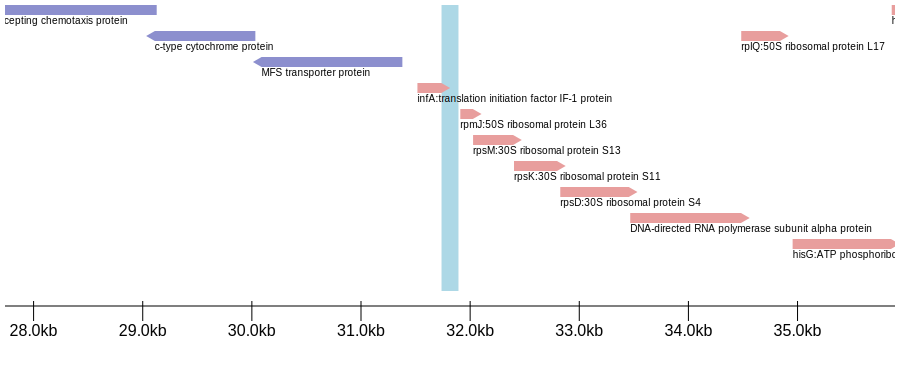

Match #1083
E-value: 1e-17
%GC: 0.32
Score: 80.1
Genome Assembly: GCF_001292505.1_RC008_S1contigs.fa
Target: NZ_CXZA01000283.1/208-118
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UUUAAAAUCCACCACUUAUUUUGAAAAUAGUUGGUUAUUCAUAAAACCUGAUGUAGUCGUAAAUCAAGUGGAAUUCAUUCAAGGAGACGCU


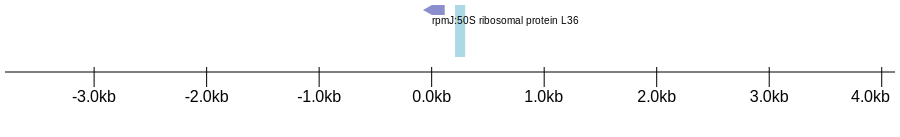

Match #1086
E-value: 3.9e-17
%GC: 0.28
Score: 78.2
Genome Assembly: GCF_000816225.1_ASM81622v1
Target: NZ_CP007771.1/76765-76920
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter lari; Campylobacter lari subsp. concheus
Matched Sequence: UCUAAGUUGUUUAAAAGCAAAAGUAAAGUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAAAAGUGGAAUUUAC


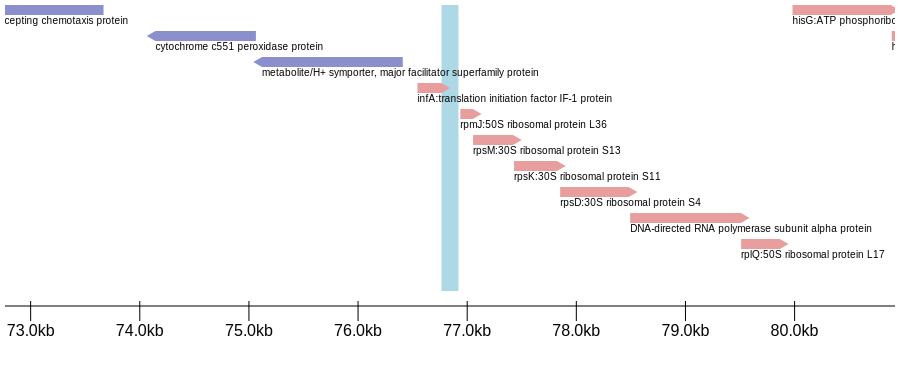

Match #1092
E-value: 4.6e-17
%GC: 0.28
Score: 78.0
Genome Assembly: GCF_003627915.1_ASM362791v1
Target: NZ_NREN01000010.1/27475-27631
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UCUAAGUUGUUUGAAAGCAAAAGUAAGAUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAUAA


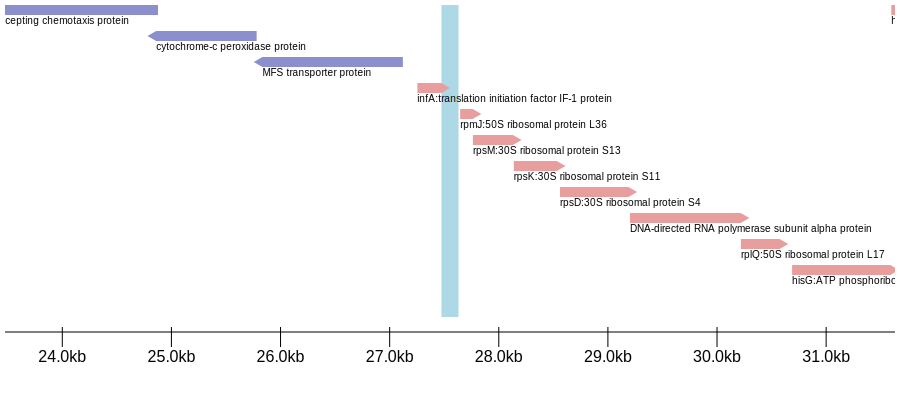

Match #1093
E-value: 6.6e-17
%GC: 0.29
Score: 77.5
Genome Assembly: GCF_000816265.1_ASM81626v1
Target: NZ_CP007772.1/85747-85901
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter subantarcticus
Matched Sequence: UCUAAGUUGUUUGAAAGCAAAAGUAAGAUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


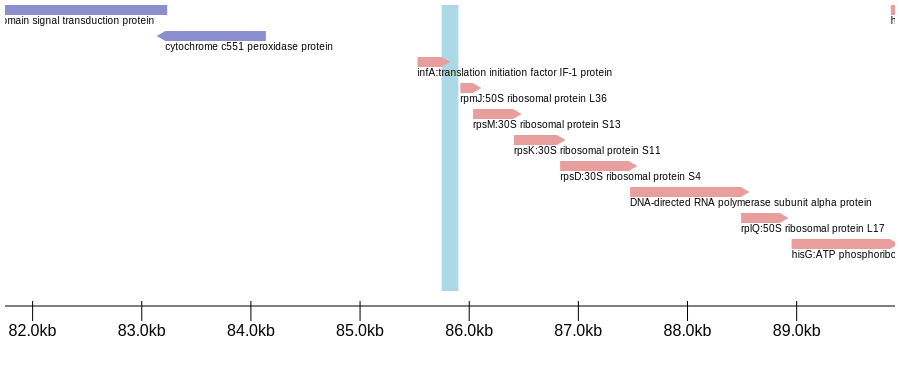

Match #1096
E-value: 2.5e-16
%GC: 0.24
Score: 75.7
Genome Assembly: GCF_008633865.1_ASM863386v1
Target: NZ_VJNS01000003.1/5835-5674
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UAAGUUUUUUAAAAGCUAAAUUUAGAUACAAUUAACCuUUUUUGCGACAAAAAUAUCCAAAAAAGAAGUAUUUUUAAAAUUUACCGCUUGUUUUAAAAAUAGUUGGUUAUUCACAAACCUAUAUGUAGUCGCAAAUuUAAGUGGAAUuUUAUUCUAGGAGAA


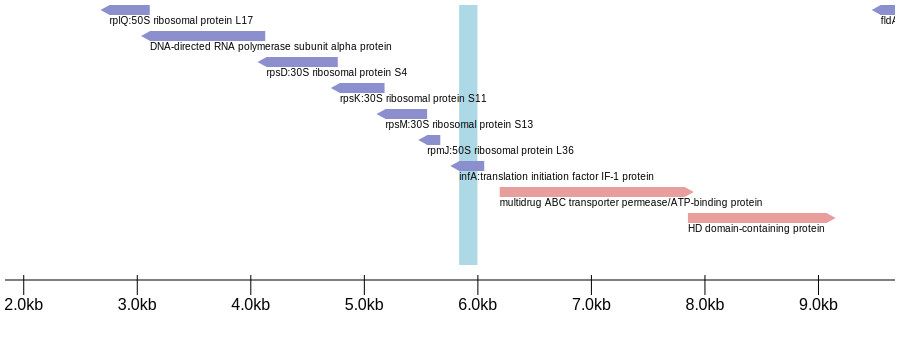

Match #1102
E-value: 4.6e-16
%GC: 0.28
Score: 74.8
Genome Assembly: GCF_000816365.1_ASM81636v1
Target: NZ_CP007775.1/94901-95055
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter lari
Matched Sequence: UCUAAGUUGUUUAAAAGCAAAAGUAAAGUAUAAUUAGGACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


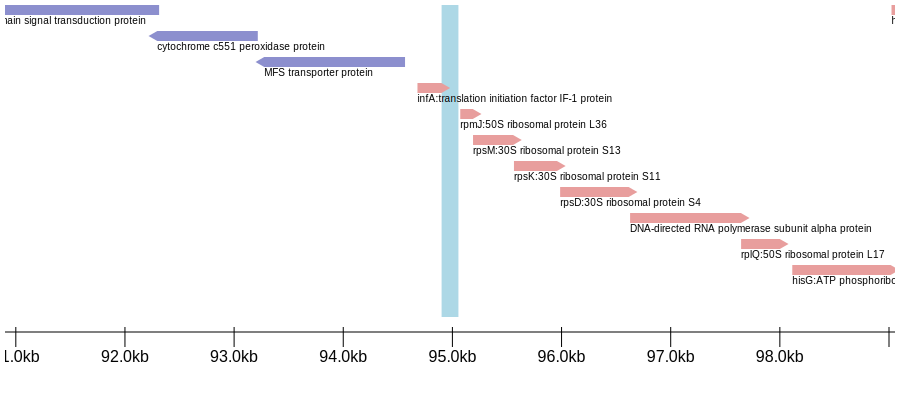

Match #1105
E-value: 4.900000000000002e-16
%GC: 0.28
Score: 74.7
Genome Assembly: GCF_000816405.1_ASM81640v1
Target: NZ_CP007777.1/85062-85216
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter lari
Matched Sequence: UCUAAGUUGUUUAAAAGCAAAAGUAAAGUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAAAGUGGAAUUUAC


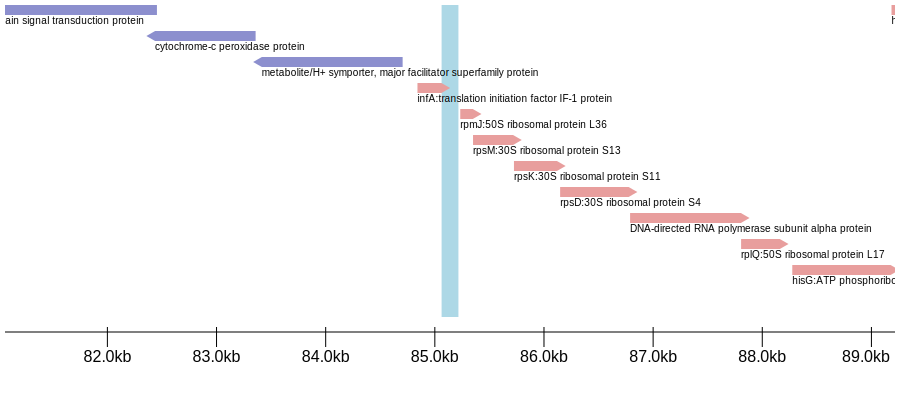

Match #1108
E-value: 6.6e-16
%GC: 0.28
Score: 74.3
Genome Assembly: GCF_000816425.1_ASM81642v1
Target: NZ_CP007778.1/91757-91913
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter lari
Matched Sequence: UCUAAGUUGUUUAAAAGCAAAAGUAAAGUAUAAUUAGCACUUUUGCAGAAAUUGCAAUAAAACUGUAUGAAGAAGUAUUUUCAAAAUCACCACUUAUUUUGAAAAUAGUUGGUUGCUCUAAAAACCUGGUGCAGUUGUAAAAaAAAGUGGAAUUUAC


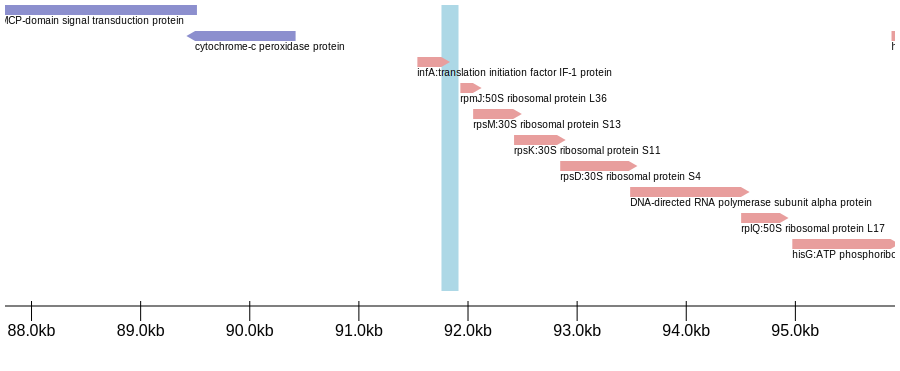

Match #1109
E-value: 1.4e-14
%GC: 0.25
Score: 70.0
Genome Assembly: GCF_000621005.1_ASM62100v1
Target: NZ_JHZL01000006.1/78242-78078
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter cuniculorum
Matched Sequence: UCUAAGUUAUUUAAAAGCUAUUUUAGAUAUAAUUAGAAUUUuUUGUGAUAUAUGCAUCAAACUACAAAGAAGUGUUUUCAAAAUUCACCACUUAUUUUGAAAAUAGUUGGUUCAUUAACCUGAUGCAUUCACAAucAAGAAGUGGAAUUUAUauauUUGAGGAGA


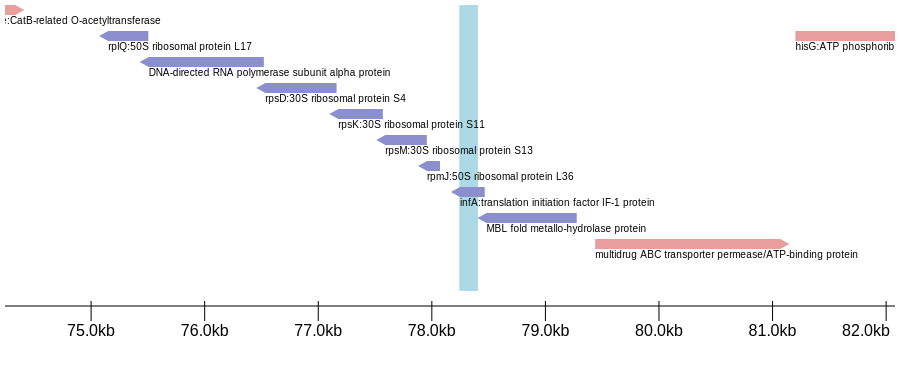

Match #1111
E-value: 4e-13
%GC: 0.31
Score: 65.4
Genome Assembly: GCF_900573945.1_B91_SCBr
Target: NZ_UWOI01000001.1/656690-656847
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UAAGUAAAUUAAAAGCUAAAUUUAGAUAUACUCAGCCCUUUGCGACAAAUUGCUGUAUGAAGAAUUGUUUUCAAAGCCCACCACUUGUUUUGAAAAUAGUUGGUUUaaaauUUCGUUAAACCUGAUGCAGCCUAAAAGUGGAAUAAAUUuUUAGGAGA


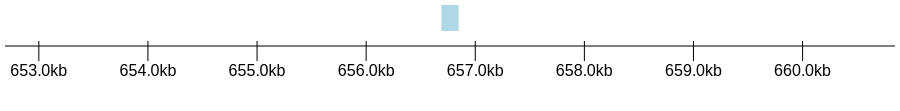

Match #1114
E-value: 8e-13
%GC: 0.27
Score: 64.4
Genome Assembly: GCF_006864365.1_ASM686436v1
Target: NZ_QHLJ01000004.1/31167-31326
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: UUUUAAAGCUAUUUUUGAUAAAAUUAAGCUUUUUGCAACAAACAAAAACUAUGCGAAGAAGUAUUUUCAAAAUUUACCACUUGUUUUGAAAAUAGUUGGUUCAACUCAAAaACCUaaAAUGCAGUUGUugcaAAAUGAAGUGGAAUUCAUUUuUAGGAGA


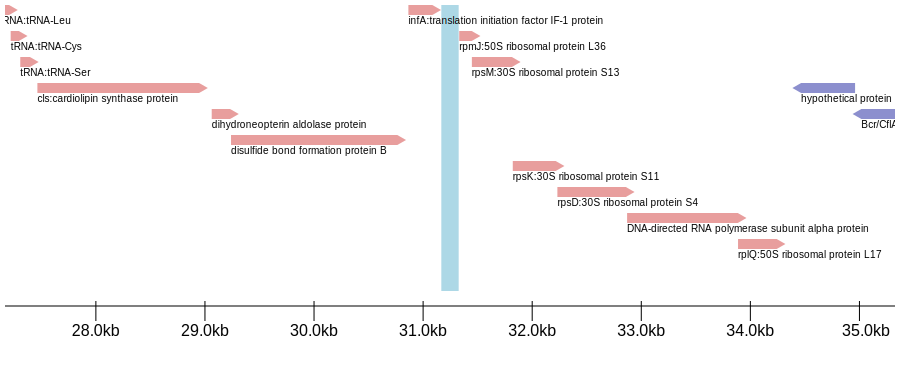

Match #1115
E-value: 3.4e-12
%GC: 0.32
Score: 62.4
Genome Assembly: GCF_000175655.1_ASM17565v1
Target: NZ_ACVQ01000008.1/57174-57017
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter showae
Matched Sequence: UAAGUAAAUUAAAAGCUAAAUUUGGCUAUACUCAGCCCUUUGCGACAAAUUGCUGUAUGAAGAAUUGUUUUCAAAGCCCACCACUUGUUUUGAAAAUAGUUGGUUUaaaauUUCGUUAAACCUGAUGCAGCCUAAAAGUGGAAUAAAUUuUUAGGAGA


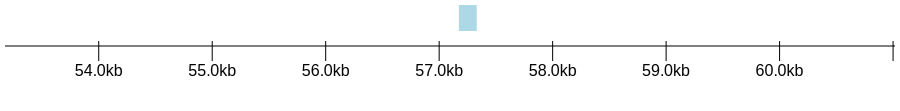

Match #1118
E-value: 3.5e-12
%GC: 0.32
Score: 62.4
Genome Assembly: GCF_902460585.1_2010-347972
Target: NZ_CABPUZ010000011.1/44160-44321
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAUUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuagauuCUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


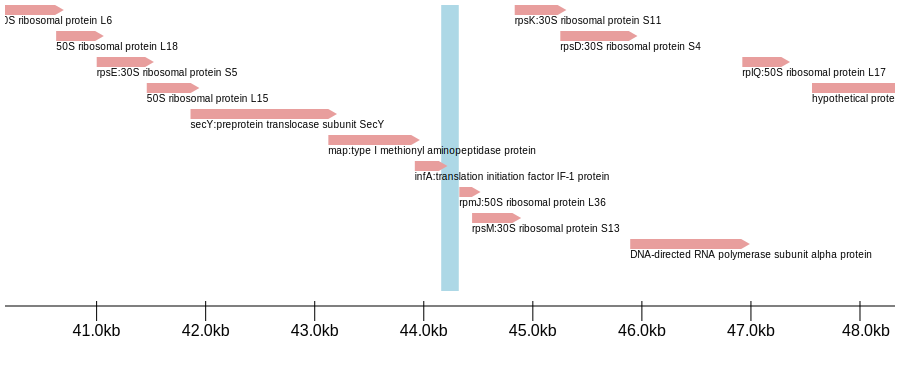

Match #1126
E-value: 4.9e-12
%GC: 0.31
Score: 61.9
Genome Assembly: GCF_003048685.1_ASM304868v1
Target: NZ_PIRI01000017.1/27481-27642
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUCCCCCACUUAUUUUGAAAAUAGUUGGUUuaaauuaUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


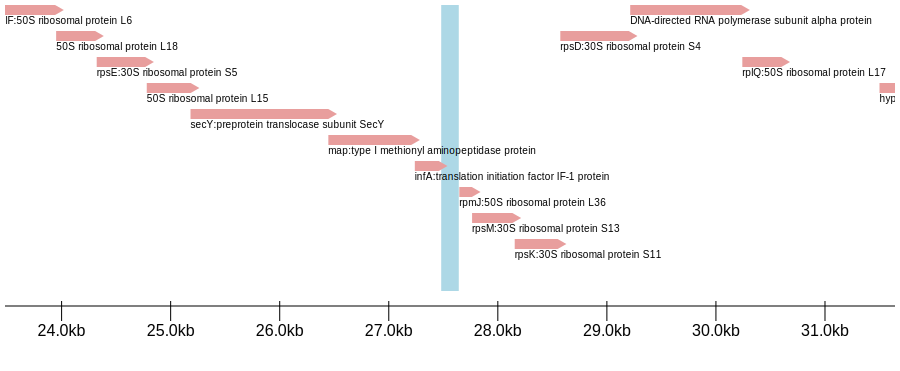

Match #1127
E-value: 5.5e-12
%GC: 0.3
Score: 61.7
Genome Assembly: GCF_003048765.1_ASM304876v1
Target: NZ_PIQU01000008.1/45378-45217
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAAACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


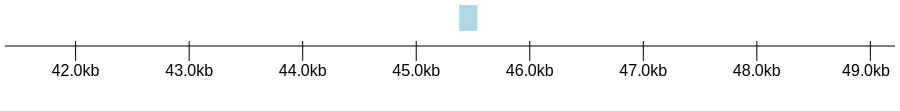

Match #1132
E-value: 7.5e-12
%GC: 0.3
Score: 61.3
Genome Assembly: GCF_001891085.1_ASM189108v1
Target: NZ_JXUP01000009.1/40965-41126
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGUUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


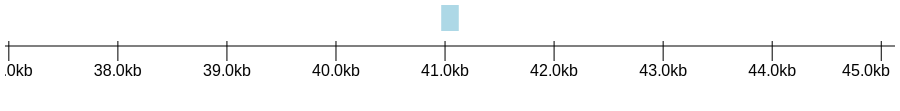

Match #1133
E-value: 1.1e-11
%GC: 0.31
Score: 60.8
Genome Assembly: GCF_003048695.1_ASM304869v1
Target: NZ_PIRE01000004.1/47847-47686
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuaaauuUCUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


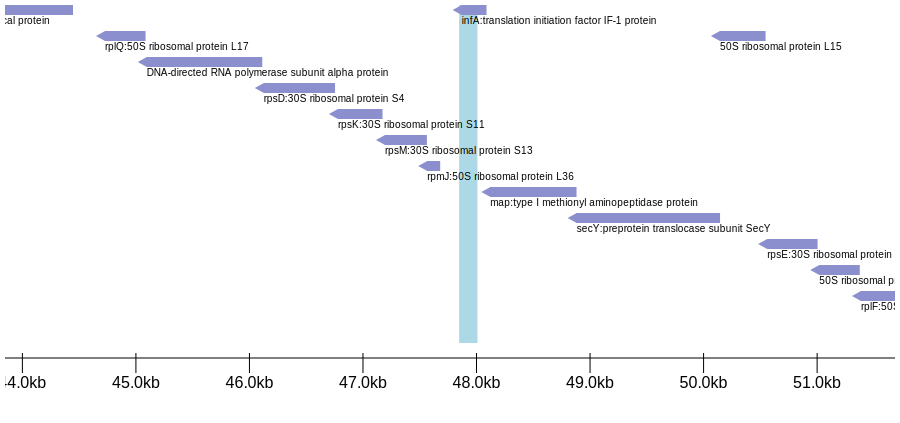

Match #1135
E-value: 1.1e-11
%GC: 0.32
Score: 60.7
Genome Assembly: GCF_004323825.1_ASM432382v1
Target: NZ_QPGQ01000021.1/47666-47823
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: UCUAAGCUAUUUAAAAGUUAUUUUCAGCUAAAAUUAUAGCUUUGCGAAGCUUUCAGCUAUGAAAAGAAGUGUUUUCAAAGUCCCACUUAUUUUGAAAACAGUUGGUUCUCAACCUAAUACGCUUUCGCAaAGUUAAGUGGAAUUUAUUUAAGGAGAUG


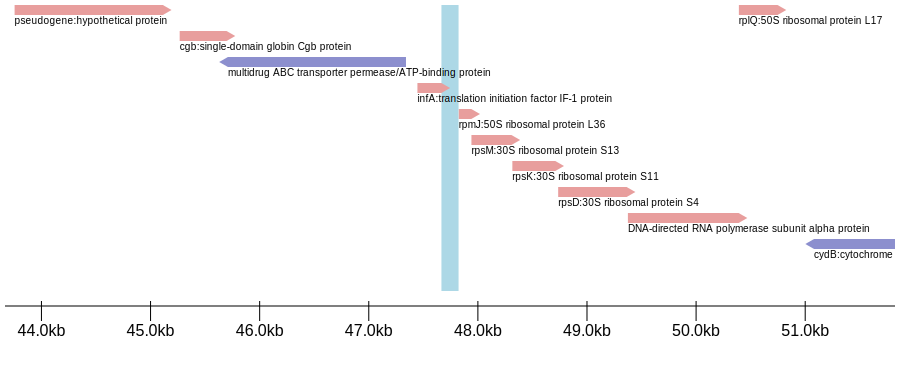

Match #1137
E-value: 1.2e-11
%GC: 0.32
Score: 60.7
Genome Assembly: GCF_005406235.1_ASM540623v1
Target: NZ_NXLK01000002.1/26868-26720
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: CUAAGCGAAGUUAAAGCUCAGUUUAGAUAAAAUUAGCGUUUUUGCUAUGCGAAGAAGUAUUUUCAAAAUUCACCACUUGUUUUGAAAAUAGUUGGUUucACUCAAAAAACCGAAGCAAAUGUGUAAGUGGAAUUuaCAUUUUAGGAGAC


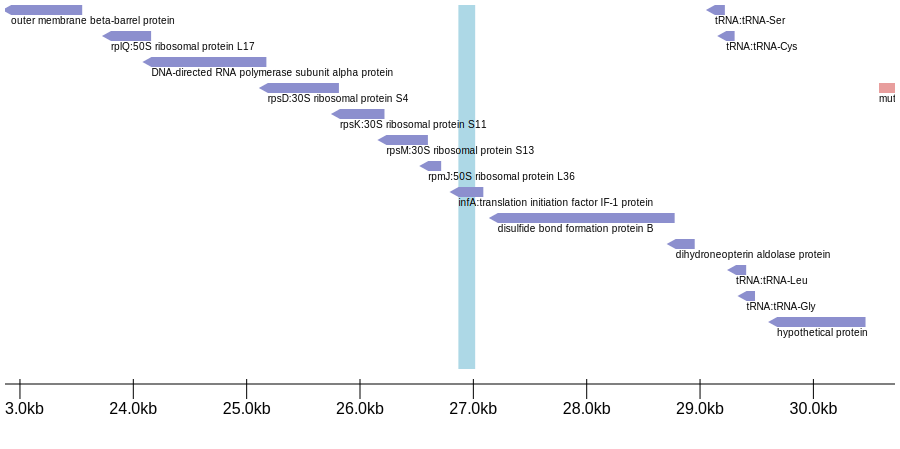

Match #1140
E-value: 1.3e-11
%GC: 0.31
Score: 60.5
Genome Assembly: GCF_002913945.1_ASM291394v1
Target: NZ_POZK01000006.1/21509-21670
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUGaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


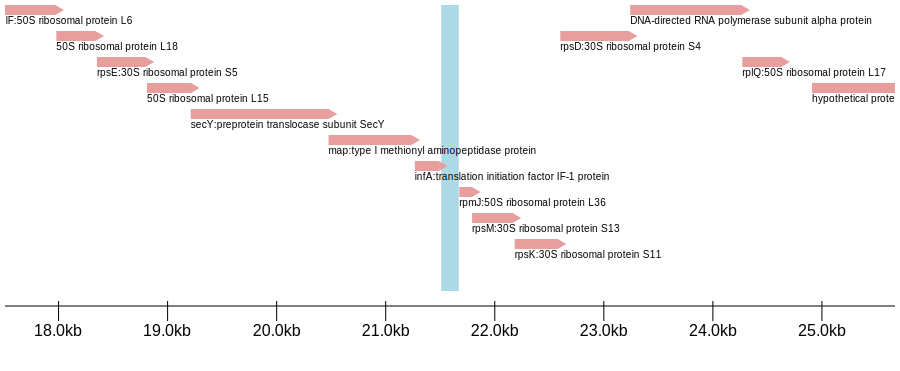

Match #1142
E-value: 1.3e-11
%GC: 0.31
Score: 60.5
Genome Assembly: GCF_902460705.1_2010-378007-O
Target: NZ_CABPUP010000005.1/55810-55971
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuaaauuUUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


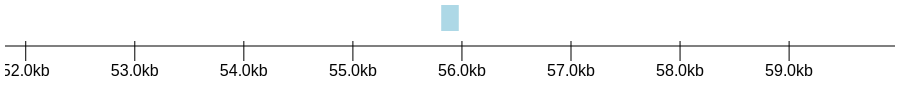

Match #1143
E-value: 1.4e-11
%GC: 0.32
Score: 60.4
Genome Assembly: GCF_000466745.1_ATCC51562
Target: NZ_ANNI01000004.1/33856-34017
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter concisus
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuagauuCUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


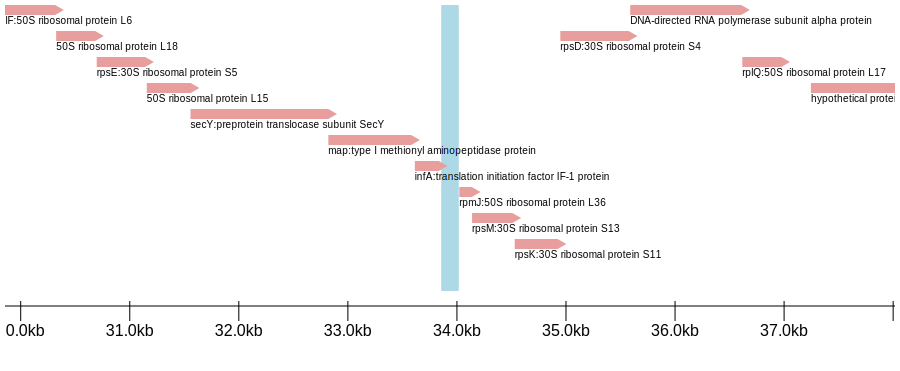

Match #1151
E-value: 1.5e-11
%GC: 0.31
Score: 60.4
Genome Assembly: GCF_003048775.1_ASM304877v1
Target: NZ_PIQT01000009.1/21648-21809
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


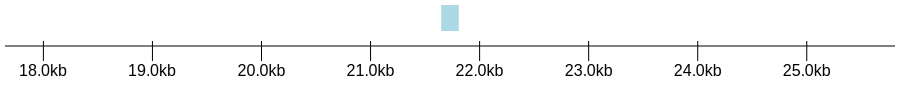

Match #1159
E-value: 1.6e-11
%GC: 0.31
Score: 60.3
Genome Assembly: GCF_002913185.1_ASM291318v1
Target: NZ_PPAS01000025.1/3278-3117
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUAGGUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


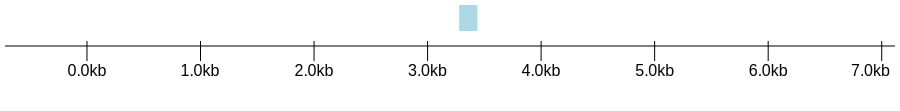

Match #1180
E-value: 1.7e-11
%GC: 0.31
Score: 60.2
Genome Assembly: GCF_003048755.1_ASM304875v1
Target: NZ_PIRW01000001.1/759636-759797
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuaaauuCUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


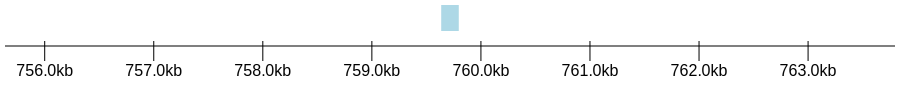

Match #1182
E-value: 1.7e-11
%GC: 0.31
Score: 60.1
Genome Assembly: GCF_003049085.1_ASM304908v1
Target: NZ_PIQX01000004.1/42281-42120
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUAGGUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUcuaaauuCUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


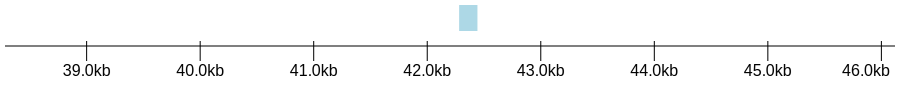

Match #1199
E-value: 1.8e-11
%GC: 0.3
Score: 60.1
Genome Assembly: GCF_002912925.1_ASM291292v1
Target: NZ_POZY01000018.1/4814-4653
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUuaaaauuUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


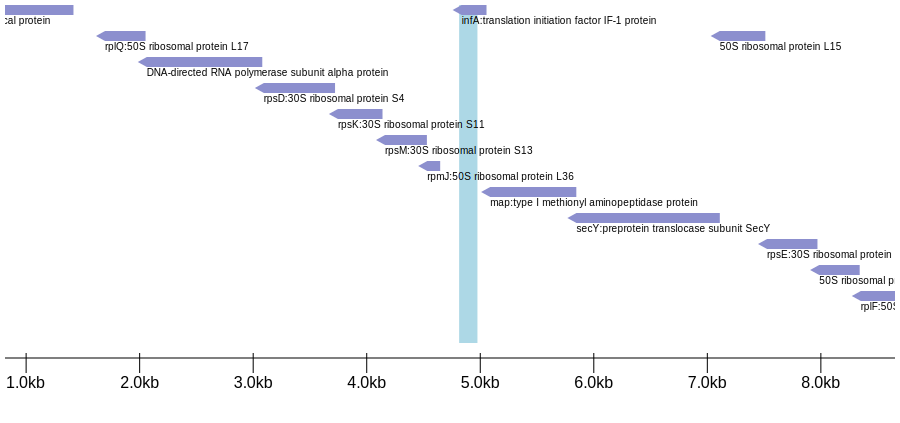

Match #1203
E-value: 2.3e-11
%GC: 0.3
Score: 59.7
Genome Assembly: GCF_000466685.1_UNSWCS
Target: NZ_ANNG01000009.1/47823-47662
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; Campylobacter concisus
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUuaaauuaUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


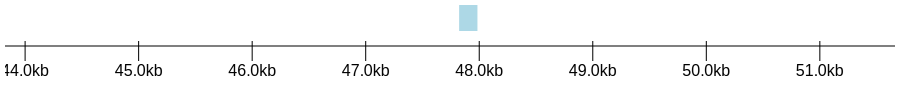

Match #1211
E-value: 2.3e-11
%GC: 0.3
Score: 59.7
Genome Assembly: GCF_002912335.1_ASM291233v1
Target: NZ_POYL01000124.1/52432-52593
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUAGGUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUuaaauuaUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


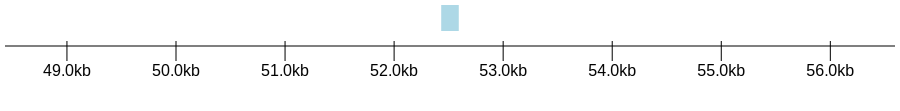

Match #1218
E-value: 2.4e-11
%GC: 0.3
Score: 59.7
Genome Assembly: GCF_902460635.1_2010-16206
Target: NZ_CABPUS010000007.1/56001-56162
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUAGUUUUGGGUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUuaaauuaUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


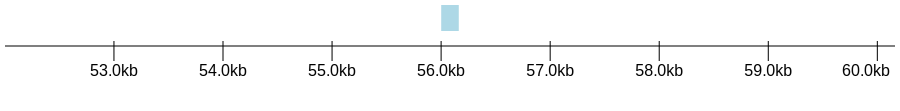

Match #1240
E-value: 2.9e-11
%GC: 0.3
Score: 59.4
Genome Assembly: GCF_902460535.1_2010-112825
Target: NZ_CABPTV010000002.1/250494-250655
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGAUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


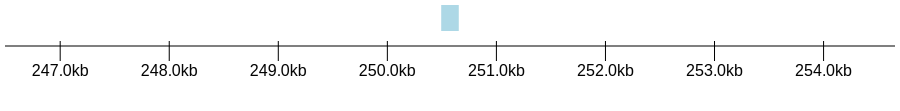

Match #1241
E-value: 3.1e-11
%GC: 0.31
Score: 59.3
Genome Assembly: GCF_902460555.1_2010-30795
Target: NZ_CABPUM010000006.1/33632-33793
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGCUUUAGGUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


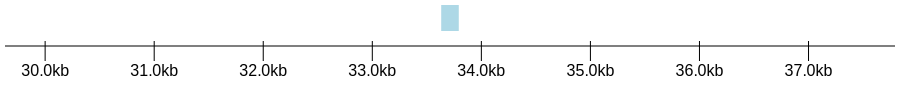

Match #1242
E-value: 3.4e-11
%GC: 0.3
Score: 59.2
Genome Assembly: GCF_003048895.1_ASM304889v1
Target: NZ_PIRG01000008.1/58114-58275
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGGUAAAAUCCAAGUUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUAGUUGGUUuaaauuaUUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


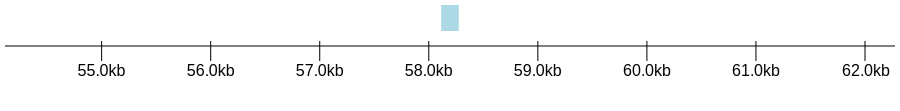

Match #1244
E-value: 3.9e-11
%GC: 0.32
Score: 59.0
Genome Assembly: GCF_000762855.1_ASM76285v1
Target: NZ_JRMR01000012.1/781-930
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter; unclassified Campylobacter
Matched Sequence: CUAAGCGAAGUUAAAGCUCAGUUUAGAUAAAAUUAGCGUUUUUGCUAUGCGAAGAAGUAUUUUCAAAAUUCACCACUUGUUUUGAAAAUAGUUGGUUucACUCAAAAAACCGAAGCAAAUGUGUAAGUGGAAUUUAcauUUUUAGGAGAC


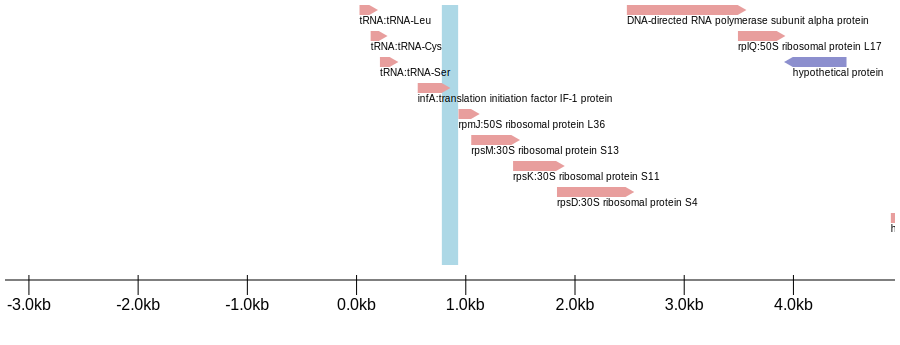

Match #1246
E-value: 4.2e-11
%GC: 0.31
Score: 58.9
Genome Assembly: GCF_003048535.1_ASM304853v1
Target: NZ_PIRQ01000010.1/17776-17615
Lineage: cellular organisms; Bacteria; Proteobacteria; delta/epsilon subdivisions; Epsilonproteobacteria; Campylobacterales; Campylobacteraceae; Campylobacter
Matched Sequence: CUAAGUAAAUUUAAAGCUGGUUUUGGAUAAAAUCCAAGCUUUGCGAAAAGCUGUAUGAAGAAUUAUUUUCAAAGUUCCCCACUUAUUUUGAAAAUGGUUGGUUUaaauucuUUCUUUAGACCUGAUGCAGCCCCUAAAAAAGUGGAAUAAAUUuUUAGGAGA


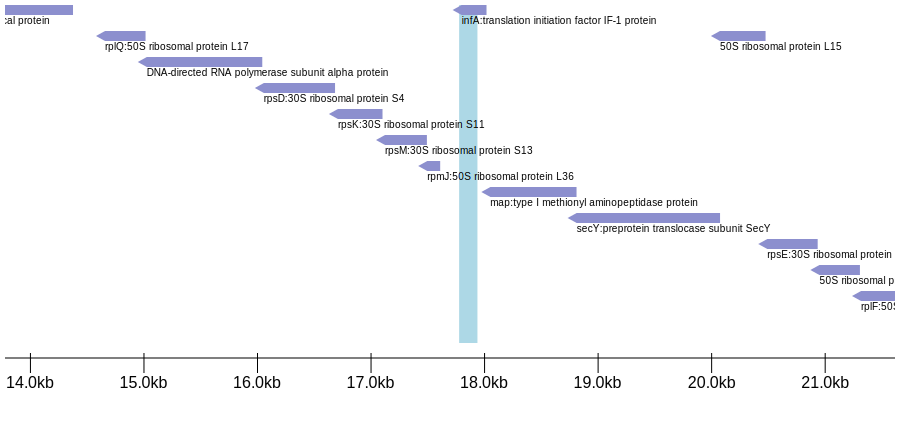

IndexError: list index out of range

In [8]:
deduped_sto_records = [record for record in sto_records if re.sub('^[0-9]+\|','',record.id) in dedupe_id_list]
results_csv_filename = "{}/{}_results.csv".format(outdir, motif_name)
if not os.path.exists(results_csv_filename):
    deduped_results_df['lineage']=''
    deduped_results_df['assembly_accession']=''
    deduped_results_df.to_csv(results_csv_filename)
get_all_images(results_csv_filename, deduped_sto_records)